In [1]:
from __future__ import annotations
import SimpleITK as sitk
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import cv2
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.exposure import equalize_adapthist
from skimage import color, exposure
from skimage.transform import resize
from pathlib import Path
from PIL import Image, ImageOps
import tifffile as tiff
from aicsimageio.writers import OmeTiffWriter

import registration_callbacks
import logging

if logging.getLogger().hasHandlers():
    logging.getLogger().handlers.clear()

from tiatoolbox.tools.registration.wsi_registration import (
    apply_bspline_transform,
    estimate_bspline_transform,
    match_histograms,
)

mpl.rcParams["figure.dpi"] = 300  # for high resolution figure in notebook
mpl.rcParams["figure.facecolor"] = "white"  # To make sure text is visible in dark mode

NUMEXPR_MAX_THREADS=8


In [3]:
def pil_to_sitk(pil_image: Image.Image) -> sitk.Image:
    """Convert a PIL image to a SimpleITK image."""
    np_image = np.array(pil_image)
    if len(np_image.shape) == 2:  # Grayscale image
        sitk_image = sitk.GetImageFromArray(np_image)
    else:  # RGB or RGBA image
        np_image = np_image[:, :, 0]  # Take the first channel
        sitk_image = sitk.GetImageFromArray(np_image)
    sitk_image.SetSpacing([1.0, 1.0])
    return sitk_image

# Function to invert the image
def invert_image(image: sitk.Image) -> sitk.Image:
    """Invert the image intensities."""
    max_intensity = sitk.GetArrayFromImage(image).max()
    return sitk.InvertIntensity(image, maximum=max_intensity)
def preprocess_image(image: np.ndarray) -> np.ndarray:
    """Pre-process image for registration using masks.

    This function converts the RGB image to grayscale image and
    improves the contrast by linearly rescaling the values.

    """
    image = color.rgb2gray(image)
    image = exposure.rescale_intensity(
        image,
        in_range=tuple(np.percentile(image, (0.5, 99.5))),
    )
    image = image * 255
    return image.astype(np.uint8)

def preprocess_image_normalized(image):
    """Normalize and adjust the contrast of an image."""
    # Convert PIL Image to NumPy array if it's a PIL Image
    if isinstance(image, Image.Image):
        image = np.array(image)

    # Normalize the image to range [0, 1]
    image_normalized = (image - image.min()) / (image.max() - image.min())

    # Apply adaptive histogram equalization
    image_eq = exposure.equalize_adapthist(image_normalized, clip_limit=0.03)

    # Convert back to 8-bit image
    image_eq = (image_eq * 255).astype(np.uint8)

    return image_eq

def preprocess_image_contrast_stretching(image):
    """Adjust the contrast of an image using contrast stretching."""
    # Convert PIL Image to NumPy array if necessary
    if isinstance(image, Image.Image):
        image = np.array(image)
    
    # Apply contrast stretching to the image
    p2, p98 = np.percentile(image, (2, 98))  # Use percentiles that best suit your data
    image = exposure.rescale_intensity(image, in_range=(p2, p98))
    
    # Convert image back to 8-bit (0-255) if not already
    image = (image * 255).astype(np.uint8)
    
    return image

def enhance_contrast(img, percentile_low, percentile_high):
    """ Enhance contrast based on percentiles to remove background noise. """
    p2, p98 = np.percentile(img, (percentile_low, percentile_high))
    img_rescale = exposure.rescale_intensity(img, in_range=(p2, p98))
    return img_rescale

# Resize images to the common shape
def resize_image(image, target_shape):
    return resize(image, target_shape, preserve_range=True, anti_aliasing=True).astype(image.dtype)

# Define the visualization function
def display_images(image_dict):
    fixed_image = image_dict['fixed']
    moving_image = image_dict['moving']
    registered_image = image_dict['registered']
    result_image = image_dict['composition']
    # Convert SimpleITK images to numpy arrays for plotting
    fixed_array = sitk.GetArrayFromImage(fixed_image)
    moving_array = sitk.GetArrayFromImage(moving_image)
    registered_array = sitk.GetArrayFromImage(registered_image)
    if result_image is not None:
        result_array = sitk.GetArrayFromImage(result_image)
    else:
        result_array = np.zeros_like(fixed_array)  # Create a placeholder array if result is None

    # Create a figure with subplots
    plt.figure(figsize=(24, 6))

    # Plot the fixed image
    plt.subplot(1, 4, 1)
    plt.imshow(fixed_array, cmap='gray')
    plt.title('Fixed Image')
    plt.axis('off')

    # Plot the moving image
    plt.subplot(1, 4, 2)
    plt.imshow(moving_array, cmap='gray')
    plt.title('Moving Image')
    plt.axis('off')

    # Plot the registered image
    plt.subplot(1, 4, 3)
    plt.imshow(registered_array, cmap='gray')
    plt.title('Registered Image')
    plt.axis('off')

    # Plot the resulting image or a placeholder
    plt.subplot(1, 4, 4)
    plt.imshow(result_array, cmap='gray')
    plt.title('Overlay Image')
    plt.axis('off')
    plt.show()

In [36]:
# import numpy as np
# import matplotlib.pyplot as plt

# def resize_image(image, shape):
#     from skimage.transform import resize
#     return resize(image, shape, preserve_range=True, anti_aliasing=True)

# def enhance_contrast(image, low_pct, high_pct):
#     p2, p98 = np.percentile(image, (low_pct, high_pct))
#     return (image - p2) / (p98 - p2)

# def preprocess_tile(tile, common_shape):
#     # Resize tile to common shape
#     tile_resized = resize_image(tile, common_shape)
#     # Expand dimensions to (height, width, 3)
#     tile_expanded = np.repeat(tile_resized[:, :, np.newaxis], 3, axis=2)
#     return tile_expanded

# def binarize_image(image, threshold_pct=90):
#     norm_image = enhance_contrast(image, 2, 98)
#     binary_image = np.where(norm_image > np.percentile(norm_image, threshold_pct), 1, 0)
#     return binary_image

# def prepare_color_image(image, channel_index):
#     color_image = np.zeros((*image.shape, 3))
#     color_image[:, :, channel_index] = binarize_image(image)
#     return color_image

# def prepare_overlay_image(moving_tile, fixed_tile):
#     return np.stack([moving_tile, fixed_tile, moving_tile], axis=-1)

# def main(fixed_tile, moving_tile, bspline_registered_image):
#     common_shape = (
#         min(fixed_tile.shape[0], moving_tile.shape[0], bspline_registered_image.shape[0]),
#         min(fixed_tile.shape[1], moving_tile.shape[1], bspline_registered_image.shape[1])
#     )

#     # Resize images to common shape
#     fixed_tile = resize_image(fixed_tile, common_shape)
#     moving_tile = resize_image(moving_tile, common_shape)
#     bspline_registered_image = resize_image(bspline_registered_image, common_shape)

#     print(f'Shape of moving WSI (H&E stitched image): {moving_tile.shape}')
#     print(f'Shape of fixed WSI (mIF stitched image): {fixed_tile.shape}')

#     # Prepare overlay images
#     tile_overlay = prepare_overlay_image(moving_tile, fixed_tile)
#     bspline_overlay = prepare_overlay_image(bspline_registered_image, fixed_tile)

#     # Prepare and process color images
#     fixed_image_color = prepare_color_image(fixed_tile, 1)  # Green channel for fixed image
#     moving_image_color = prepare_color_image(moving_tile, 0)  # Red channel for moving image
#     moving_image_color[:, :, 2] = moving_image_color[:, :, 0]  # Blue channel for moving image

#     bspline_registered_color = prepare_color_image(bspline_registered_image, 0)  # Red channel for registered image
#     bspline_registered_color[:, :, 2] = bspline_registered_color[:, :, 0]  # Blue channel for registered image

#     # Plot the results
#     fig, axs = plt.subplots(1, 4, figsize=(20, 15))
#     axs[0].imshow(fixed_tile, cmap='viridis')
#     axs[0].set_title("mIF WSI", fontsize=12, fontweight='bold')

#     axs[1].imshow(moving_tile, cmap='viridis')
#     axs[1].set_title("H&E WSI before registration", fontsize=12, fontweight='bold')

#     axs[2].imshow(bspline_registered_image)
#     axs[2].set_title("Registered H&E WSI", fontsize=12, fontweight='bold')

#     axs[3].imshow(bspline_overlay)
#     axs[3].set_title("Overlay WSIs After B-spline Transform", fontsize=12, fontweight='bold')

#     for ax in axs:
#         ax.set_xlabel("X")
#         ax.set_ylabel("Y")
#         ax.axis('off')

#     # Adjust layout
#     plt.tight_layout()
#     plt.subplots_adjust(top=0.85)  # Adjust the top to ensure titles are within the figure
#     plt.show()

# # Example usage:
# # fixed_tile = <load your fixed_tile image>
# # moving_tile = <load your moving_tile image>
# # bspline_registered_image = <load your bspline_registered_image>
# # main(fixed_tile, moving_tile, bspline_registered_image)


Shape of fixed image (483, 599, 3)
Shape of moving image (421, 596, 3)


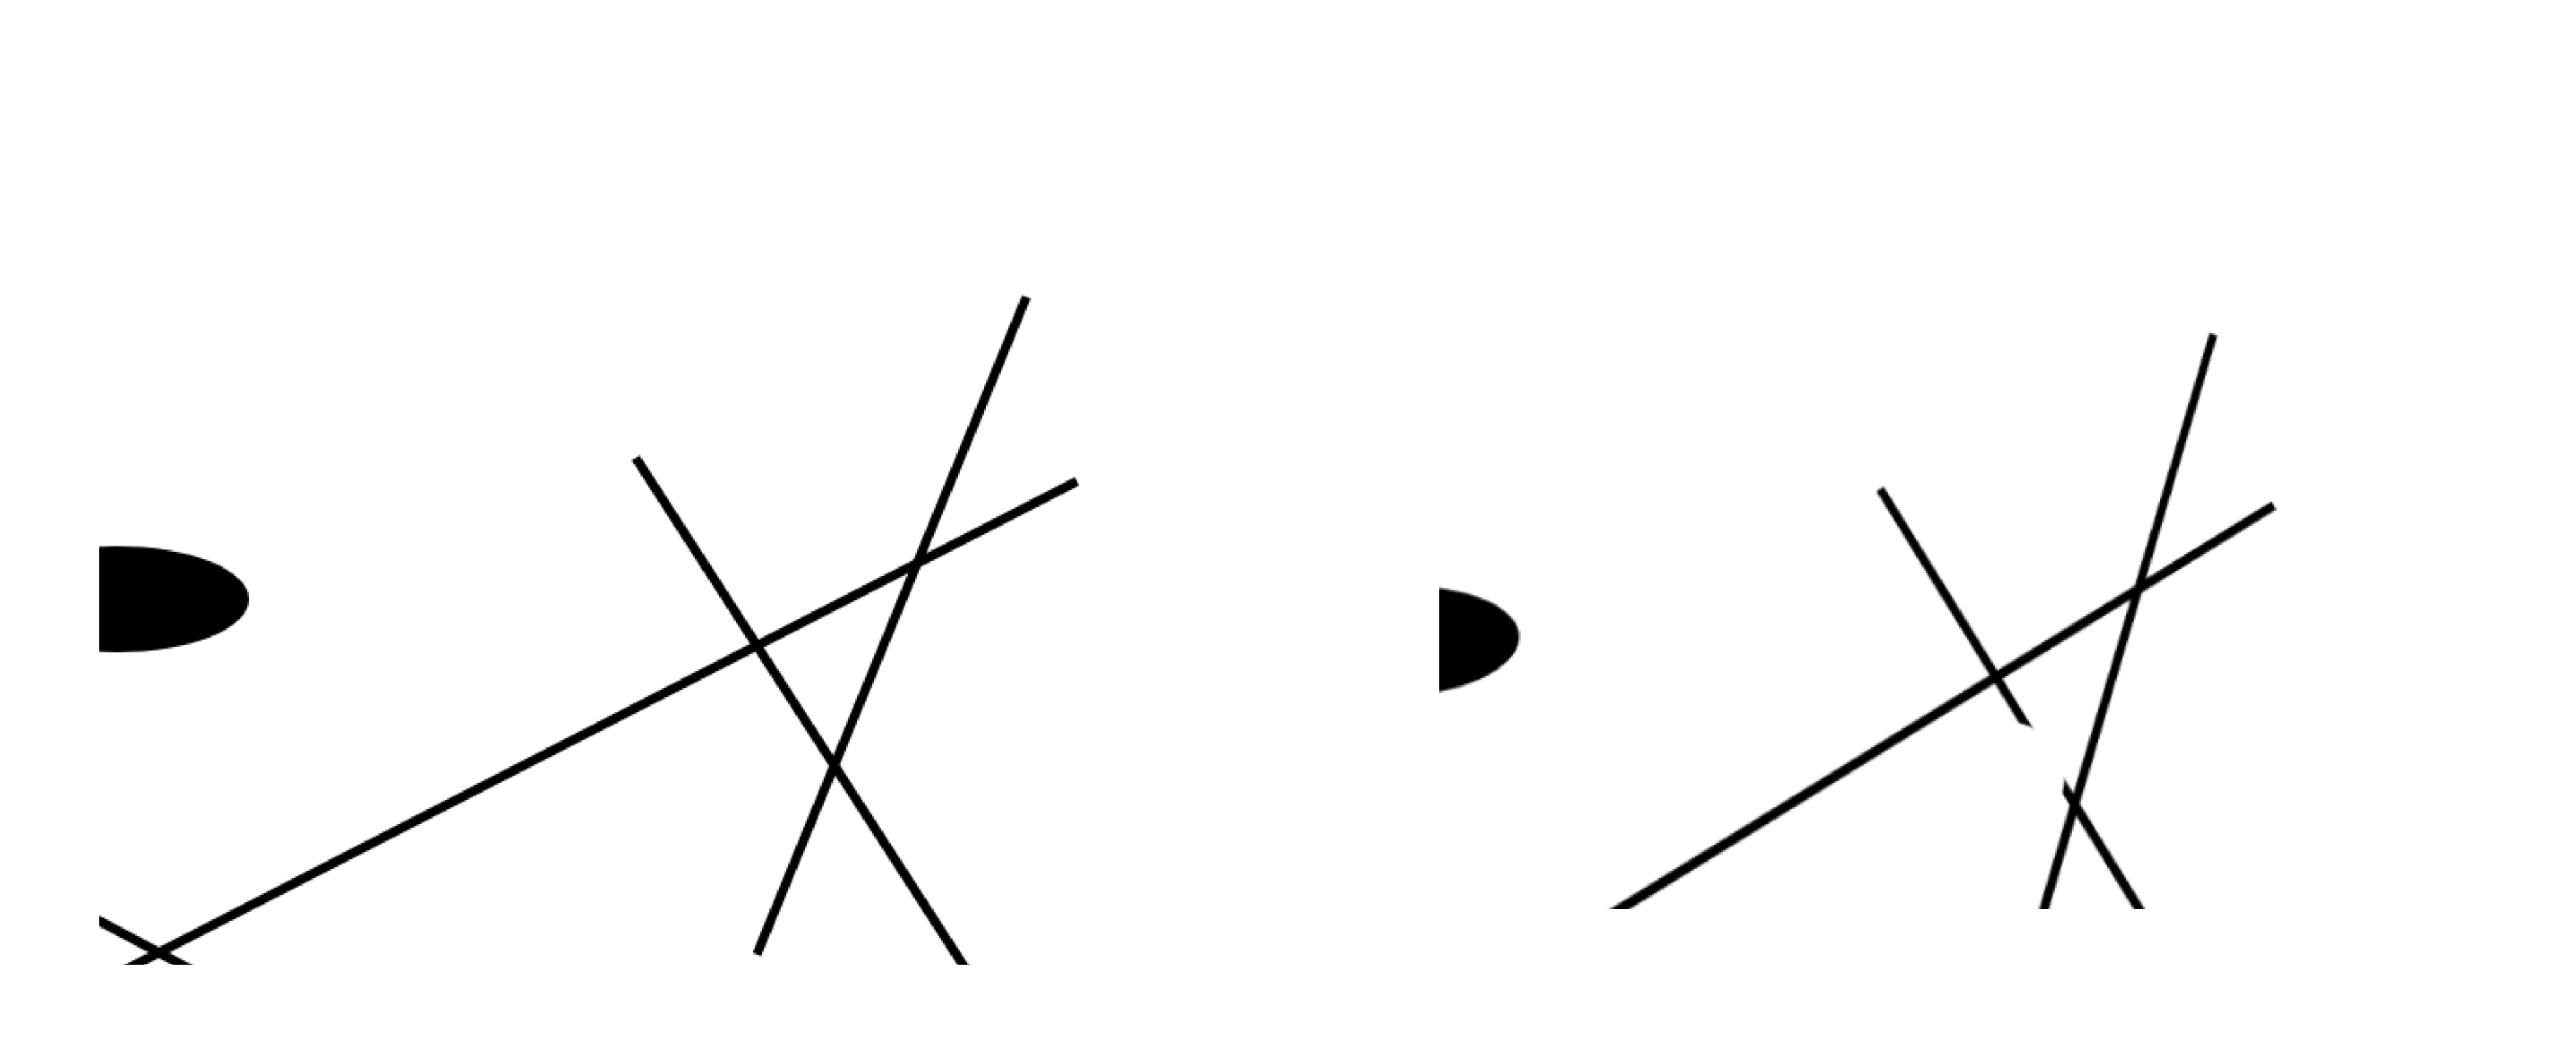

Shape of moving WSI (H&E stitched image) (421, 596)
Shape of fixed WSI (mIF stitched image) (421, 596)
Shape of fixed WSI (mIF stitched image) before expandation (421, 596)
Shape of fixed WSI (mIF stitched image) after expandation (421, 596)
Shape of moving WSI (H&E stitched image) before expandation (421, 596)
Shape of moving WSI (H&E stitched image) after expandation (421, 596, 3)
Shape of registered moving WSI (H&E stitched image) before expandation (421, 596)
Shape of registered moving WSI (H&E stitched image) after expandation (421, 596)


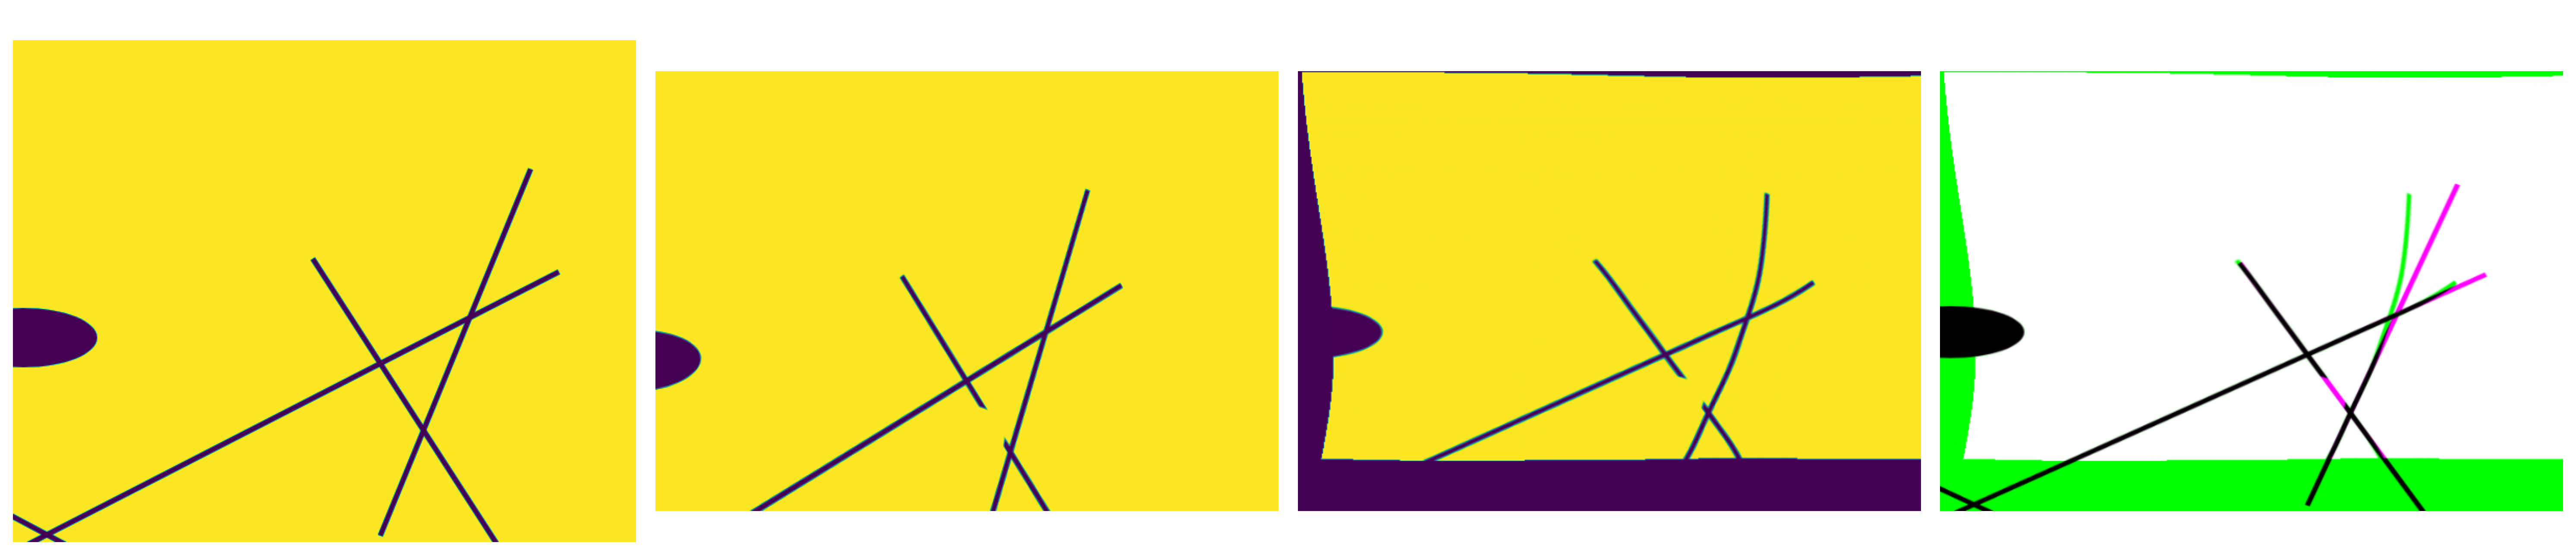

In [44]:
fixed_image_path = '/Users/linh/Library/Mobile Documents/com~apple~CloudDocs/example-toy-images-for-registration/data/image-target-1-2.png'

moving_image_path = '/Users/linh/Library/Mobile Documents/com~apple~CloudDocs/example-toy-images-for-registration/data/tiled/image-simple-1-2.png'

fixed_image_data = cv2.imread(fixed_image_path)
print("Shape of fixed image", fixed_image_data.shape)

moving_image_data = cv2.imread(moving_image_path)
print("Shape of moving image", moving_image_data.shape)


fixed_image = preprocess_image(fixed_image_data)
moving_image = preprocess_image(moving_image_data)

# fixed_image, moving_image = match_histograms(fixed_image, moving_image)

# Visualising the results
_, axs = plt.subplots(1, 2, figsize=(15, 10))
axs[0].imshow(fixed_image, cmap="gray")
axs[0].set_title("Fixed Image")
axs[1].imshow(moving_image, cmap="gray")
axs[1].set_title("Moving Image")
plt.show()

fixed_tile = fixed_image
moving_tile = moving_image
# fixed_tile = fixed_image_color
# moving_tile = moving_image_color
fixed_mask = np.ones(shape=fixed_tile.shape, dtype=int)
moving_mask = np.ones(shape=moving_tile.shape, dtype=int)

bspline_transform = estimate_bspline_transform(
    fixed_tile,
    moving_tile,
    fixed_mask,
    moving_mask,
    # default parameters
    grid_space = 50.0,
    scale_factors = [1, 2, 5],
    shrink_factor = [4, 2, 1],
    smooth_sigmas = [4, 2, 1],
    num_iterations = 100,
    sampling_percent = 0.2,
    learning_rate = 0.5,
    convergence_min_value = 1e-4,
    convergence_window_size = 5,
)

bspline_registered_image = apply_bspline_transform(
    fixed_tile,
    moving_tile,
    bspline_transform,
)
bspline_registered_image.shape
common_shape = (min(fixed_tile.shape[0], moving_tile.shape[0], bspline_registered_image.shape[0]),
                min(fixed_tile.shape[1], moving_tile.shape[1], bspline_registered_image.shape[1]))

# Assume fixed_tile, moving_tile, and bspline_registered_image are 2D arrays (grayscale images)

# Since they are 2D, there is no need to index the third dimension.
# If you need a 3-channel image for some reason, you can duplicate the grayscale image across three channels:
fixed_tile = resize_image(fixed_tile, common_shape)
moving_tile = resize_image(moving_tile, common_shape)
bspline_registered_image = resize_image(bspline_registered_image, common_shape)
print(f'Shape of moving WSI (H&E stitched image) {moving_tile.shape}')
print(f'Shape of fixed WSI (mIF stitched image) {fixed_tile.shape}')

tile_overlay = np.stack([moving_tile, fixed_tile, moving_tile], axis=-1)
bspline_overlay = np.stack([bspline_registered_image, fixed_tile, bspline_registered_image], axis=-1)

print(f'Shape of fixed WSI (mIF stitched image) before expandation {fixed_tile.shape}')
fixed_tile = np.repeat(np.expand_dims(fixed_tile, axis=2), 3, axis=2)
print(f'Shape of fixed WSI (mIF stitched image) after expandation {moving_tile.shape}')
# Transpose moviing_tile array
fixed_tile = np.transpose(fixed_tile, (2, 0, 1))
first_channel_fixed = fixed_tile[0, :, :]
# Enhance contrast
fixed_image_norm = enhance_contrast(first_channel_fixed, 2, 98)

# Convert to binary using a lower percentile threshold
fixed_image_binary = np.where(fixed_image_norm > np.percentile(fixed_image_norm, 90), 1, 0)  # Using 90th percentile for threshold

# Initialize the RGB image with zeros (black background)
fixed_image_color = np.zeros((fixed_image_norm.shape[0], fixed_image_norm.shape[1], 3))

# Assign the binary mask to the purple channel (red + blue)
# fixed_image_color[:, :, 0] = fixed_image_binary  # Red channel
fixed_image_color[:, :, 1] = fixed_image_binary  # Green channel
# fixed_image_color[:, :, 2] = fixed_image_binary  # Blue channel

print(f'Shape of moving WSI (H&E stitched image) before expandation {moving_tile.shape}')
moving_tile = np.repeat(np.expand_dims(moving_tile, axis=2), 3, axis=2)
print(f'Shape of moving WSI (H&E stitched image) after expandation {moving_tile.shape}')
# Transpose moviing_tile array
moving_tile = np.transpose(moving_tile, (2, 0, 1))
first_channel_moving = moving_tile[0, :, :]
# Enhance contrast
moving_image_norm = enhance_contrast(first_channel_moving, 2, 98)

# Convert to binary using a lower percentile threshold
moving_image_binary = np.where(moving_image_norm > np.percentile(moving_image_norm, 90), 1, 0)  # Using 90th percentile for threshold

# Initialize the RGB image with zeros (black background)
moving_image_color = np.zeros((moving_image_norm.shape[0], moving_image_norm.shape[1], 3))

# Assign the binary mask to the purple channel (red + blue)
moving_image_color[:, :, 0] = moving_image_binary  # Red channel
moving_image_color[:, :, 2] = moving_image_binary  # Blue channel

print(f'Shape of registered moving WSI (H&E stitched image) before expandation {bspline_registered_image.shape}')
bspline_registered_tile = np.repeat(np.expand_dims(bspline_registered_image, axis=2), 3, axis=2)
print(f'Shape of registered moving WSI (H&E stitched image) after expandation {bspline_registered_image.shape}')
# Transpose moviing_tile array
bspline_registered_tile = np.transpose(bspline_registered_tile, (2, 0, 1))
first_channel_moving = bspline_registered_tile[0, :, :]
# Enhance contrast
bspline_registered_norm = enhance_contrast(first_channel_moving, 2, 98)

# Convert to binary using a lower percentile threshold
bspline_registered_binary = np.where(bspline_registered_norm > np.percentile(bspline_registered_norm, 90), 1, 0)  # Using 90th percentile for threshold

# Initialize the RGB image with zeros (black background)
bspline_registered_color = np.zeros((bspline_registered_norm.shape[0], bspline_registered_norm.shape[1], 3))

# Assign the binary mask to the purple channel (red + blue)
bspline_registered_color[:, :, 0] = bspline_registered_binary  # Red channel
bspline_registered_color[:, :, 2] = bspline_registered_binary  # Blue channel



fig, axs = plt.subplots(1, 4, figsize=(20, 15))
axs[0].imshow(fixed_image, cmap='viridis' )
axs[0].set_title("mIF WSI", fontsize=12, fontweight='bold')

axs[1].imshow(moving_image, cmap='viridis' )
axs[1].set_title("H&E WSI before registration", fontsize=12, fontweight='bold')

axs[2].imshow(bspline_registered_image )
axs[2].set_title("Registered H&E WSI", fontsize=12, fontweight='bold')

# axs[1].imshow(tile_overlay, cmap="gray")
# axs[1].set_title("Before B-spline Transform")
axs[3].imshow(bspline_overlay)
axs[3].set_title("Overlay WSIs After B-spline Transform", fontsize=12, fontweight='bold')

for ax in axs:
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.axis('off') 
# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.85)  # Adjust the top to ensure titles are within the figure
# plt.savefig("debug_image.png")
plt.show()

Shape of fixed image (309, 601, 3)
Shape of moving image (385, 675, 3)


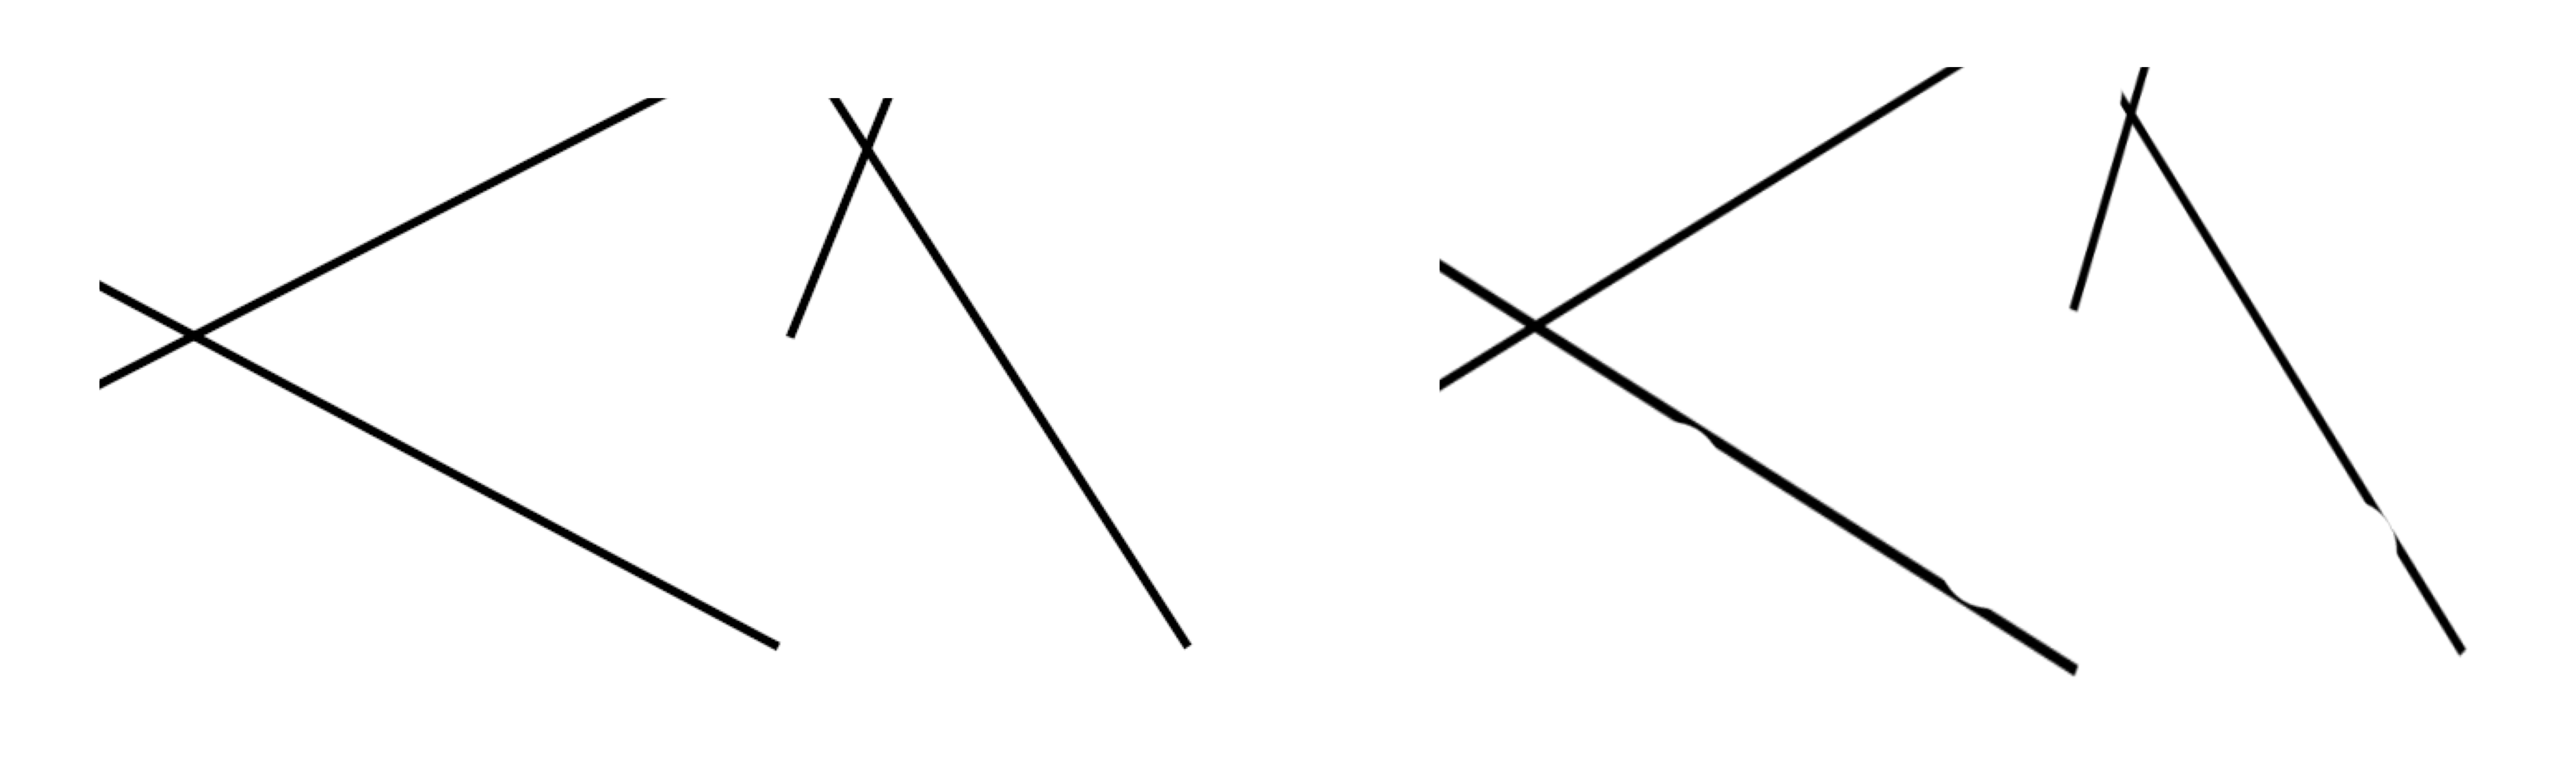

Shape of moving WSI (H&E stitched image) (309, 601)
Shape of fixed WSI (mIF stitched image) (309, 601)
Shape of fixed WSI (mIF stitched image) before expandation (309, 601)
Shape of fixed WSI (mIF stitched image) after expandation (309, 601)
Shape of moving WSI (H&E stitched image) before expandation (309, 601)
Shape of moving WSI (H&E stitched image) after expandation (309, 601, 3)
Shape of registered moving WSI (H&E stitched image) before expandation (309, 601)
Shape of registered moving WSI (H&E stitched image) after expandation (309, 601)


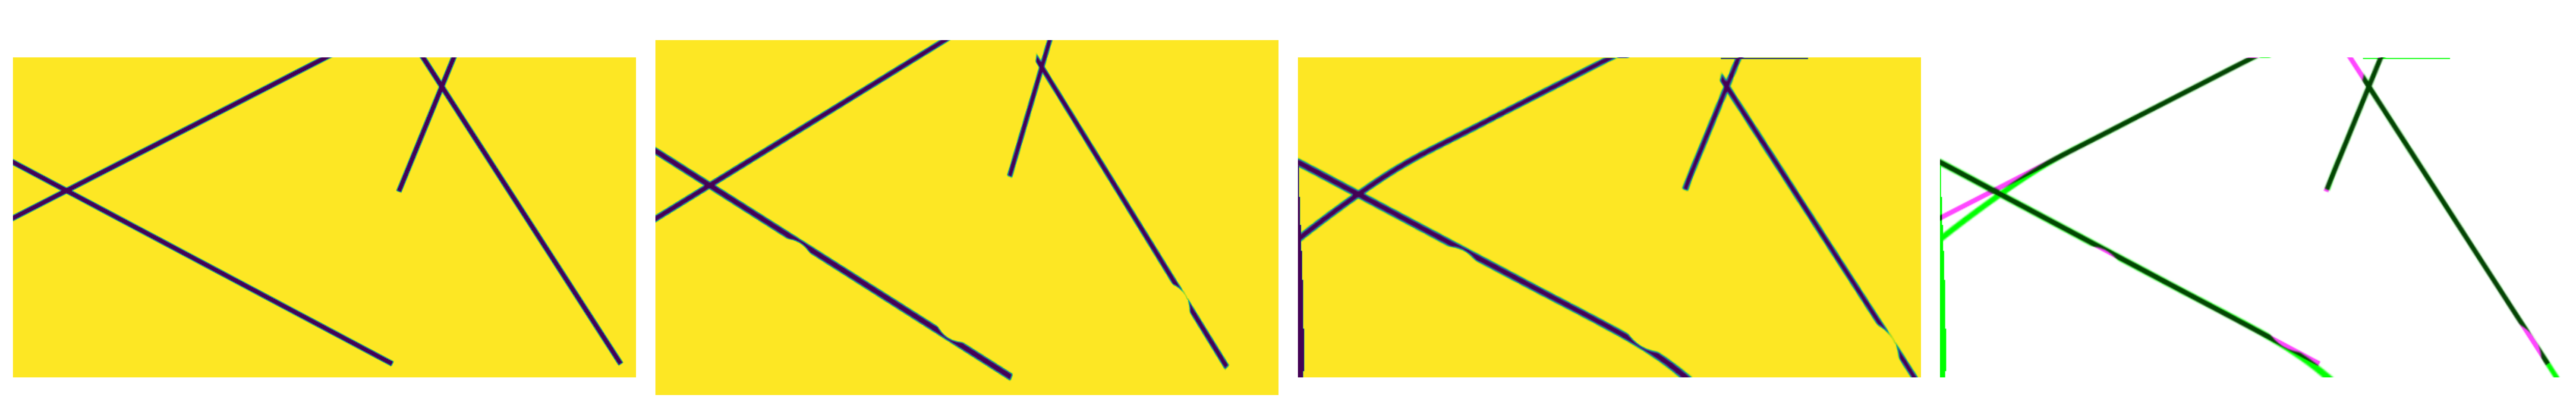

In [16]:
# fixed_image_path = '/Users/linh/Downloads/example-toy-images-for-registration/data/image-target-1-.png'
fixed_image_path = '/Users/linh/Library/Mobile Documents/com~apple~CloudDocs/example-toy-images-for-registration/data/image-target-1-4.png'
# fixed_image_path = '/Users/linh/Downloads/example-toy-images-for-registration/data/image-target-image.png'
moving_image_path = '/Users/linh/Library/Mobile Documents/com~apple~CloudDocs/example-toy-images-for-registration/data/tiled/image-simple-1-4.png'


fixed_image_data = cv2.imread(fixed_image_path)
print("Shape of fixed image", fixed_image_data.shape)

# first_channel_fixed = fixed_image_data[0, :, :]
# three_channel_image_fixed = np.stack([first_channel_fixed] * 3, axis=-1)
# # fixed_image_rgb = Image.fromarray(three_channel_image_fixed.astype('uint8'), 'RGB')

# fixed_image_norm = enhance_contrast(first_channel_fixed, 2, 98)
# # Convert to binary using a lower percentile threshold
# fixed_image_binary = np.where(fixed_image_norm > np.percentile(fixed_image_norm, 90), 1, 0)  # Using 90th percentile for threshold
# fixed_image_color = np.zeros((fixed_image_norm.shape[0], fixed_image_norm.shape[1], 3))
# fixed_image_color[:, :, 1] = fixed_image_binary # Green channel

moving_image_data = cv2.imread(moving_image_path)
print("Shape of moving image", moving_image_data.shape)

# first_channel_moving = moving_image_data[0, :, :]
# three_channel_image_moving = np.stack([first_channel_moving] * 3, axis=-1)

# # moving_image_rgb = Image.fromarray(three_channel_image_moving.astype('uint8'), 'RGB')

# moving_image_norm = enhance_contrast(first_channel_moving, 2, 98)
# # Convert to binary using a lower percentile threshold
# moving_image_binary = np.where(moving_image_norm > np.percentile(moving_image_norm, 90), 1, 0)  # Using 90th percentile for threshold
# moving_image_color = np.zeros((moving_image_norm.shape[0], moving_image_norm.shape[1], 3))
# # moving_image_color[:, :, 1] = moving_image_binary # Green channel
# # Assign the binary mask to the purple channel (red + blue)
# moving_image_color[:, :, 0] = moving_image_binary  # Red channel
# moving_image_color[:, :, 2] = moving_image_binary  # Blue channel



fixed_image = preprocess_image(fixed_image_data)
moving_image = preprocess_image(moving_image_data)

fixed_image, moving_image = match_histograms(fixed_image, moving_image)

# Visualising the results
_, axs = plt.subplots(1, 2, figsize=(15, 10))
axs[0].imshow(fixed_image, cmap="gray")
axs[0].set_title("Fixed Image")
axs[1].imshow(moving_image, cmap="gray")
axs[1].set_title("Moving Image")
plt.show()

fixed_tile = fixed_image
moving_tile = moving_image
# fixed_tile = fixed_image_color
# moving_tile = moving_image_color
fixed_mask = np.ones(shape=fixed_tile.shape, dtype=int)
moving_mask = np.ones(shape=moving_tile.shape, dtype=int)

bspline_transform = estimate_bspline_transform(
    fixed_tile,
    moving_tile,
    fixed_mask,
    moving_mask,
    # grid_space=50.0,
    # scale_factors=[1, 2, 5, 10],
    # shrink_factor=[8, 4, 2, 1],
    # smooth_sigmas=[8, 4, 2, 1],
    # num_iterations=10000,
    # sampling_percent=0.2,
    # learning_rate=1e-6,
    # convergence_min_value=1e-10,
    # covergence_window_size=1
)

bspline_registered_image = apply_bspline_transform(
    fixed_tile,
    moving_tile,
    bspline_transform,
)
bspline_registered_image.shape
common_shape = (min(fixed_tile.shape[0], moving_tile.shape[0], bspline_registered_image.shape[0]),
                min(fixed_tile.shape[1], moving_tile.shape[1], bspline_registered_image.shape[1]))

# Assume fixed_tile, moving_tile, and bspline_registered_image are 2D arrays (grayscale images)

# Since they are 2D, there is no need to index the third dimension.
# If you need a 3-channel image for some reason, you can duplicate the grayscale image across three channels:
fixed_tile = resize_image(fixed_tile, common_shape)
moving_tile = resize_image(moving_tile, common_shape)
bspline_registered_image = resize_image(bspline_registered_image, common_shape)
print(f'Shape of moving WSI (H&E stitched image) {moving_tile.shape}')
print(f'Shape of fixed WSI (mIF stitched image) {fixed_tile.shape}')

tile_overlay = np.stack([moving_tile, fixed_tile, moving_tile], axis=-1)
bspline_overlay = np.stack([bspline_registered_image, fixed_tile, bspline_registered_image], axis=-1)

print(f'Shape of fixed WSI (mIF stitched image) before expandation {fixed_tile.shape}')
fixed_tile = np.repeat(np.expand_dims(fixed_tile, axis=2), 3, axis=2)
print(f'Shape of fixed WSI (mIF stitched image) after expandation {moving_tile.shape}')
# Transpose moviing_tile array
fixed_tile = np.transpose(fixed_tile, (2, 0, 1))
first_channel_fixed = fixed_tile[0, :, :]
# Enhance contrast
fixed_image_norm = enhance_contrast(first_channel_fixed, 2, 98)

# Convert to binary using a lower percentile threshold
fixed_image_binary = np.where(fixed_image_norm > np.percentile(fixed_image_norm, 90), 1, 0)  # Using 90th percentile for threshold

# Initialize the RGB image with zeros (black background)
fixed_image_color = np.zeros((fixed_image_norm.shape[0], fixed_image_norm.shape[1], 3))

# Assign the binary mask to the purple channel (red + blue)
# fixed_image_color[:, :, 0] = fixed_image_binary  # Red channel
fixed_image_color[:, :, 1] = fixed_image_binary  # Green channel
# fixed_image_color[:, :, 2] = fixed_image_binary  # Blue channel

print(f'Shape of moving WSI (H&E stitched image) before expandation {moving_tile.shape}')
moving_tile = np.repeat(np.expand_dims(moving_tile, axis=2), 3, axis=2)
print(f'Shape of moving WSI (H&E stitched image) after expandation {moving_tile.shape}')
# Transpose moviing_tile array
moving_tile = np.transpose(moving_tile, (2, 0, 1))
first_channel_moving = moving_tile[0, :, :]
# Enhance contrast
moving_image_norm = enhance_contrast(first_channel_moving, 2, 98)

# Convert to binary using a lower percentile threshold
moving_image_binary = np.where(moving_image_norm > np.percentile(moving_image_norm, 90), 1, 0)  # Using 90th percentile for threshold

# Initialize the RGB image with zeros (black background)
moving_image_color = np.zeros((moving_image_norm.shape[0], moving_image_norm.shape[1], 3))

# Assign the binary mask to the purple channel (red + blue)
moving_image_color[:, :, 0] = moving_image_binary  # Red channel
moving_image_color[:, :, 2] = moving_image_binary  # Blue channel

print(f'Shape of registered moving WSI (H&E stitched image) before expandation {bspline_registered_image.shape}')
bspline_registered_tile = np.repeat(np.expand_dims(bspline_registered_image, axis=2), 3, axis=2)
print(f'Shape of registered moving WSI (H&E stitched image) after expandation {bspline_registered_image.shape}')
# Transpose moviing_tile array
bspline_registered_tile = np.transpose(bspline_registered_tile, (2, 0, 1))
first_channel_moving = bspline_registered_tile[0, :, :]
# Enhance contrast
bspline_registered_norm = enhance_contrast(first_channel_moving, 2, 98)

# Convert to binary using a lower percentile threshold
bspline_registered_binary = np.where(bspline_registered_norm > np.percentile(bspline_registered_norm, 90), 1, 0)  # Using 90th percentile for threshold

# Initialize the RGB image with zeros (black background)
bspline_registered_color = np.zeros((bspline_registered_norm.shape[0], bspline_registered_norm.shape[1], 3))

# Assign the binary mask to the purple channel (red + blue)
bspline_registered_color[:, :, 0] = bspline_registered_binary  # Red channel
bspline_registered_color[:, :, 2] = bspline_registered_binary  # Blue channel

fig, axs = plt.subplots(1, 4, figsize=(20, 15))
axs[0].imshow(fixed_image, cmap='viridis' )
axs[0].set_title("mIF WSI", fontsize=12, fontweight='bold')

axs[1].imshow(moving_image, cmap='viridis' )
axs[1].set_title("H&E WSI before registration", fontsize=12, fontweight='bold')

axs[2].imshow(bspline_registered_image )
axs[2].set_title("Registered H&E WSI", fontsize=12, fontweight='bold')

# axs[1].imshow(tile_overlay, cmap="gray")
# axs[1].set_title("Before B-spline Transform")
axs[3].imshow(bspline_overlay)
axs[3].set_title("Overlay WSIs After B-spline Transform", fontsize=12, fontweight='bold')

for ax in axs:
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.axis('off') 
# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.85)  # Adjust the top to ensure titles are within the figure
# plt.savefig("debug_image.png")
plt.show()

In [17]:
import SimpleITK as sitk
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage import exposure

RGB_IMAGE_DIM = 3
BIN_MASK_DIM = 2

def command_iteration(method):
    print(f"{method.GetOptimizerIteration():3} = {method.GetMetricValue():10.5f}")

def estimate_bspline_transform(fixed_image, moving_image, fixed_mask, moving_mask, **kwargs):
    bspline_params = {
        "grid_space": 50.0,
        "scale_factors": [1, 2, 5],
        "shrink_factor": [4, 2, 1],
        "smooth_sigmas": [4, 2, 1],
        "num_iterations": 100,
        "sampling_percent": 0.2,
        "learning_rate": 0.5,
        "convergence_min_value": 1e-4,
        "convergence_window_size": 5,
    }
    bspline_params.update(kwargs)

    fixed_image, moving_image = np.squeeze(fixed_image), np.squeeze(moving_image)
    if fixed_image.ndim > RGB_IMAGE_DIM or moving_image.ndim > RGB_IMAGE_DIM:
        raise ValueError("The input images can only be grayscale or RGB images.")
    if (fixed_image.ndim == RGB_IMAGE_DIM and fixed_image.shape[2] != RGB_IMAGE_DIM) or \
       (moving_image.ndim == RGB_IMAGE_DIM and moving_image.shape[2] != RGB_IMAGE_DIM):
        raise ValueError("The input images can only have 3 channels.")

    fixed_image_inv = np.invert(fixed_image)
    moving_image_inv = np.invert(moving_image)

    fixed_mask = np.array(fixed_mask != 0, dtype=np.uint8)
    moving_mask = np.array(moving_mask != 0, dtype=np.uint8)

    fixed_image_inv = cv2.bitwise_and(fixed_image_inv, fixed_image_inv, mask=fixed_mask)
    moving_image_inv = cv2.bitwise_and(moving_image_inv, moving_image_inv, mask=moving_mask)

    fixed_image_inv_sitk = sitk.GetImageFromArray(fixed_image_inv)
    moving_image_inv_sitk = sitk.GetImageFromArray(moving_image_inv)

    fixed_image_inv_sitk = sitk.Cast(fixed_image_inv_sitk, sitk.sitkFloat32)
    moving_image_inv_sitk = sitk.Cast(moving_image_inv_sitk, sitk.sitkFloat32)

    grid_physical_spacing = [bspline_params["grid_space"]] * 2
    image_physical_size = [size * spacing for size, spacing in zip(fixed_image_inv_sitk.GetSize(), fixed_image_inv_sitk.GetSpacing())]
    mesh_size = [int(image_size / grid_spacing + 0.5) for image_size, grid_spacing in zip(image_physical_size, grid_physical_spacing)]
    mesh_size = [int(sz / 4 + 0.5) for sz in mesh_size]

    transform = sitk.BSplineTransformInitializer(fixed_image_inv_sitk, transformDomainMeshSize=mesh_size)
    print(f"Initial Number of B-spline Parameters: {transform.GetNumberOfParameters()}")

    registration_method = sitk.ImageRegistrationMethod()
    registration_method.SetInitialTransformAsBSpline(transform, inPlace=True, scaleFactors=bspline_params["scale_factors"])
    registration_method.SetMetricAsMattesMutualInformation(50)
    registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
    registration_method.SetMetricSamplingPercentage(bspline_params["sampling_percent"], sitk.sitkWallClock)
    registration_method.SetShrinkFactorsPerLevel(bspline_params["shrink_factor"])
    registration_method.SetSmoothingSigmasPerLevel(bspline_params["smooth_sigmas"])
    registration_method.SetOptimizerAsGradientDescentLineSearch(
        learningRate=bspline_params["learning_rate"],
        numberOfIterations=bspline_params["num_iterations"],
        convergenceMinimumValue=bspline_params["convergence_min_value"],
        convergenceWindowSize=bspline_params["convergence_window_size"],
    )
    registration_method.SetInterpolator(sitk.sitkLinear)

    # Add registration progress commands
    registration_method.AddCommand(sitk.sitkIterationEvent, lambda: command_iteration(registration_method))
    # registration_method.AddCommand(sitk.sitkStartEvent, registration_callbacks.metric_start_plot)
    # registration_method.AddCommand(sitk.sitkEndEvent, registration_callbacks.metric_end_plot)
    # registration_method.AddCommand(sitk.sitkMultiResolutionIterationEvent, 
    #                             registration_callbacks.metric_update_multires_iterations) 
    # registration_method.AddCommand(sitk.sitkIterationEvent, 
    #                             lambda: registration_callbacks.metric_plot_values(registration_method))

    bspline_transform = registration_method.Execute(fixed_image_inv_sitk, moving_image_inv_sitk)
    print("-------")
    print(bspline_transform)
    print(f"Optimizer stop condition: {registration_method.GetOptimizerStopConditionDescription()}")
    print(f"Iteration: {registration_method.GetOptimizerIteration()}")
    print(f"Metric value: {registration_method.GetMetricValue()}")

    return bspline_transform

def apply_bspline_transform(fixed_image, moving_image, transform):
    fixed_image_sitk = sitk.GetImageFromArray(fixed_image)
    moving_image_sitk = sitk.GetImageFromArray(moving_image)

    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(fixed_image_sitk)
    resampler.SetInterpolator(sitk.sitkLinear)
    resampler.SetDefaultPixelValue(1)
    resampler.SetTransform(transform)

    registered_image_sitk = resampler.Execute(moving_image_sitk)
    registered_image = sitk.GetArrayFromImage(registered_image_sitk)

    simg1 = sitk.Cast(sitk.RescaleIntensity(fixed_image_sitk), sitk.sitkFloat32)
    simg2 = sitk.Cast(sitk.RescaleIntensity(registered_image_sitk), sitk.sitkFloat32)
    cimg = sitk.Compose(simg1, simg2, simg1 // 2 + simg2 // 2)

    return {"fixed": sitk.GetArrayFromImage(simg1), "moving": sitk.GetArrayFromImage(simg2), "registered": registered_image, "composition": sitk.GetArrayFromImage(cimg)}

def display_images(image_dict):
    fixed_image = image_dict['fixed']
    moving_image = image_dict['moving']
    registered_image = image_dict['registered']
    result_image = image_dict['composition']

    plt.figure(figsize=(24, 6))
    titles = ['Fixed Image', 'Moving Image', 'Registered Image', 'Overlay Image']
    images = [fixed_image, moving_image, registered_image, result_image]

    for i, (title, img) in enumerate(zip(titles, images)):
        plt.subplot(1, 4, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(title)
        plt.axis('off')

    plt.show()

Shape of fixed image (309, 601, 3)
Shape of moving image (385, 675, 3)
Initial Number of B-spline Parameters: 60
  0 =   -0.11803
  1 =   -0.11805
  2 =   -0.11814
  3 =   -0.11864
  4 =   -0.12195
  5 =   -0.12932
  6 =   -0.13289
  7 =   -0.14154
  8 =   -0.20009
  9 =   -0.20783
 10 =   -0.20789
 11 =   -0.21360
 12 =   -0.21778
 13 =   -0.21925
 14 =   -0.22056
 15 =   -0.22135
 16 =   -0.22192
 17 =   -0.22229
 18 =   -0.22252
 19 =   -0.22264
 20 =   -0.22272
  0 =   -0.11867
  1 =   -0.12050
  2 =   -0.12110
  3 =   -0.12127
  4 =   -0.12146
  5 =   -0.12160
  6 =   -0.12179
  7 =   -0.12194
  8 =   -0.12223
  9 =   -0.12243
 10 =   -0.12278
 11 =   -0.12294
 12 =   -0.12323
 13 =   -0.12347
 14 =   -0.12388
 15 =   -0.12404
 16 =   -0.12430
 17 =   -0.12450
 18 =   -0.12482
 19 =   -0.12504
 20 =   -0.12533
 21 =   -0.12539
 22 =   -0.12555
 23 =   -0.12562
  0 =   -0.07685
  1 =   -0.07763
  2 =   -0.07793
  3 =   -0.07813
  4 =   -0.07831
  5 =   -0.07845
  6 =   -0.07860
  7

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-------
itk::simple::BSplineTransform
 BSplineTransform (0x3a2dedbd0)
   RTTI typeinfo:   itk::BSplineTransform<double, 2u, 3u>
   Reference Count: 3
   Modified Time: 1198420
   Debug: Off
   Object Name: 
   Observers: 
     none
   CoefficientImage: [ 0x3a2df2df0, 0x3a2de7810 ]
   TransformDomainOrigin: [0, 0]
   TransformDomainPhysicalDimensions: [600, 308]
   TransformDomainDirection: 1 0
0 1

   TransformDomainMeshSize: [15, 10]
   GridSize: [18, 13]
   GridOrigin: [-40, -30.8]
   GridSpacing: [40, 30.8]
   GridDirection: 1 0
0 1


Optimizer stop condition: GradientDescentLineSearchOptimizerv4Template: Convergence checker passed at iteration 88.
Iteration: 88
Metric value: -0.0969078925825245


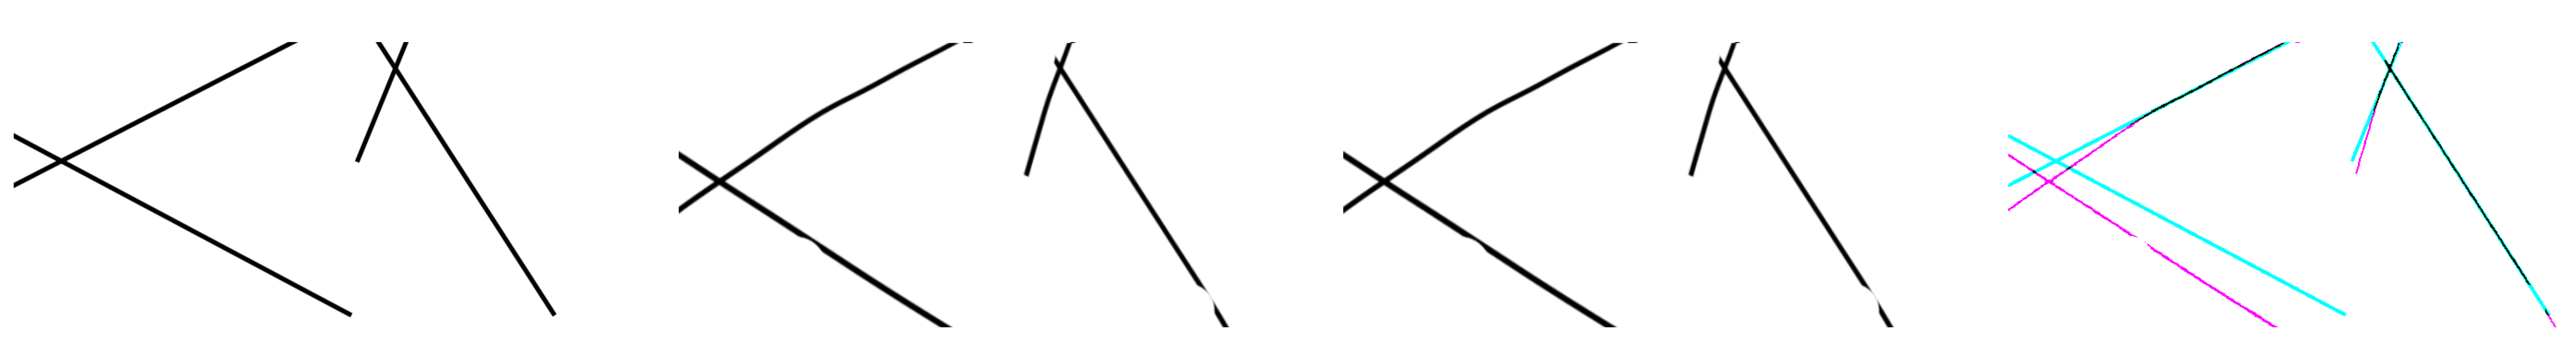

In [18]:


fixed_image_path = '/Users/linh/Library/Mobile Documents/com~apple~CloudDocs/example-toy-images-for-registration/data/image-target-1-4.png'
moving_image_path = '/Users/linh/Library/Mobile Documents/com~apple~CloudDocs/example-toy-images-for-registration/data/tiled/image-simple-1-4.png'


fixed_image_data = cv2.imread(fixed_image_path)
print("Shape of fixed image", fixed_image_data.shape)


moving_image_data = cv2.imread(moving_image_path)
print("Shape of moving image", moving_image_data.shape)

fixed_image = preprocess_image(fixed_image_data)
moving_image = preprocess_image(moving_image_data)

# fixed_image, moving_image = match_histograms(fixed_image, moving_image)

fixed_tile = fixed_image
moving_tile = moving_image

fixed_mask = np.ones(shape=fixed_tile.shape, dtype=int)
moving_mask = np.ones(shape=moving_tile.shape, dtype=int)

bspline_transform = estimate_bspline_transform(
    fixed_tile,
    moving_tile,
    fixed_mask,
    moving_mask,
)

result_images = apply_bspline_transform(
    fixed_tile,
    moving_tile,
    bspline_transform,
)

    
display_images(result_images)

Shape of fixed image (309, 601, 3)
Shape of moving image (385, 675, 3)
Initial Number of B-spline Parameters: 60
  0 =   -0.13105
  1 =   -0.13106
  2 =   -0.13114
  3 =   -0.13161
  4 =   -0.13467
  5 =   -0.14090
  6 =   -0.15921
  7 =   -0.18192
  8 =   -0.19839
  9 =   -0.20448
 10 =   -0.21327
 11 =   -0.21460
 12 =   -0.21523
 13 =   -0.21556
 14 =   -0.21586
 15 =   -0.21604
 16 =   -0.21621
 17 =   -0.21636
 18 =   -0.21652
 19 =   -0.21667
 20 =   -0.21688
 21 =   -0.21715
 22 =   -0.21749
 23 =   -0.21776
 24 =   -0.21798
 25 =   -0.21813
 26 =   -0.21827
  0 =   -0.09534
  1 =   -0.09847
  2 =   -0.09887
  3 =   -0.09911
  4 =   -0.09924
  5 =   -0.09940
  6 =   -0.09950
  7 =   -0.09967
  8 =   -0.09977
  9 =   -0.09997
 10 =   -0.10006
 11 =   -0.10029
 12 =   -0.10059
 13 =   -0.10127
 14 =   -0.10196
 15 =   -0.10251
 16 =   -0.10295
 17 =   -0.10332
 18 =   -0.10352
 19 =   -0.10371
 20 =   -0.10386
 21 =   -0.10406
 22 =   -0.10426
 23 =   -0.10457
 24 =   -0.10474
 25

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-------
itk::simple::BSplineTransform
 BSplineTransform (0x340252400)
   RTTI typeinfo:   itk::BSplineTransform<double, 2u, 3u>
   Reference Count: 3
   Modified Time: 1316936
   Debug: Off
   Object Name: 
   Observers: 
     none
   CoefficientImage: [ 0x3402602d0, 0x34025fbd0 ]
   TransformDomainOrigin: [0, 0]
   TransformDomainPhysicalDimensions: [600, 308]
   TransformDomainDirection: 1 0
0 1

   TransformDomainMeshSize: [15, 10]
   GridSize: [18, 13]
   GridOrigin: [-40, -30.8]
   GridSpacing: [40, 30.8]
   GridDirection: 1 0
0 1


Optimizer stop condition: GradientDescentLineSearchOptimizerv4Template: Convergence checker passed at iteration 28.
Iteration: 28
Metric value: -0.07684793370466354


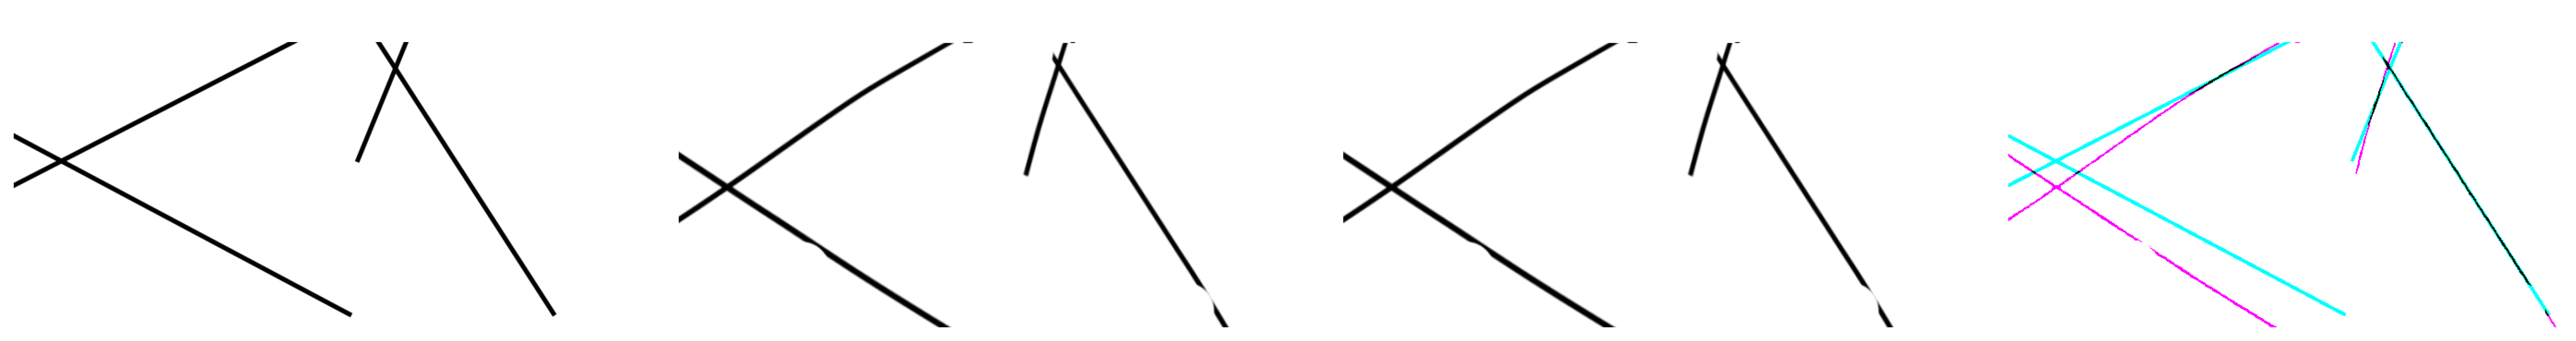

In [19]:
fixed_image_path = '/Users/linh/Library/Mobile Documents/com~apple~CloudDocs/example-toy-images-for-registration/data/image-target-1-4.png'
moving_image_path = '/Users/linh/Library/Mobile Documents/com~apple~CloudDocs/example-toy-images-for-registration/data/tiled/image-simple-1-4.png'


fixed_image_data = cv2.imread(fixed_image_path)
print("Shape of fixed image", fixed_image_data.shape)


moving_image_data = cv2.imread(moving_image_path)
print("Shape of moving image", moving_image_data.shape)

fixed_image = preprocess_image(fixed_image_data)
moving_image = preprocess_image(moving_image_data)

# fixed_image, moving_image = match_histograms(fixed_image, moving_image)

fixed_tile = fixed_image
moving_tile = moving_image
# fixed_tile = fixed_image_color
# moving_tile = moving_image_color
fixed_mask = np.ones(shape=fixed_tile.shape, dtype=int)
moving_mask = np.ones(shape=moving_tile.shape, dtype=int)
# grid_space=50.0,
# scale_factors=[1, 2, 5, 10],
# shrink_factor=[8, 4, 2, 1],
# smooth_sigmas=[8, 4, 2, 1],
# num_iterations=10000,
# sampling_percent=0.2,
# learning_rate=1e-6,
# convergence_min_value=1e-10,
# covergence_window_size=1
bspline_transform = estimate_bspline_transform(
    fixed_tile,
    moving_tile,
    fixed_mask,
    moving_mask,

)

result_images = apply_bspline_transform(
    fixed_tile,
    moving_tile,
    bspline_transform,
)
def display_images(image_dict):
    fixed_image = image_dict['fixed']
    moving_image = image_dict['moving']
    registered_image = image_dict['registered']
    result_image = image_dict['composition']

    plt.figure(figsize=(24, 6))
    titles = ['Fixed Image', 'Moving Image', 'Registered Image', 'Overlay Image']
    images = [fixed_image, moving_image, registered_image, result_image]

    for i, (title, img) in enumerate(zip(titles, images)):
        plt.subplot(1, 4, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(title)
        plt.axis('off')

    plt.show()
    
display_images(result_images)

In [9]:
# from sklearn.model_selection import ParameterGrid

# param_grid = {
#     'grid_space': [50.0, 100.0],
#     'scale_factors': [[1, 2, 5], [1, 2, 5, 10]],
#     'shrink_factor': [[8, 4, 2, 1], [4, 2, 1]],
#     'smooth_sigmas': [[8, 4, 2, 1], [4, 2, 1]],
#     'num_iterations': [1000, 10000],
#     'sampling_percent': [0.1, 0.2],
#     'learning_rate': [1e-5, 1e-6],
#     'convergence_min_value': [1e-10, 1e-8],
#     'convergence_window_size': [1, 5]
# }

# best_params = None
# best_metric = -np.inf
# all_results = []

# for params in ParameterGrid(param_grid):
#     print(f"Testing parameters: {params}")
#     try:
#         bspline_transform = estimate_bspline_transform(
#             fixed_image, moving_image, fixed_mask, moving_mask, **params
#         )
#         result_images = apply_bspline_transform(fixed_image, moving_image, bspline_transform)
        
#         # Example metric: Mutual Information between fixed and registered images
#         metric = sitk.MattesMutualInformationImageToImageMetricv4()
#         metric.SetFixedImage(sitk.GetImageFromArray(fixed_image))
#         metric.SetMovingImage(sitk.GetImageFromArray(result_images['registered']))
#         current_metric_value = -metric.Evaluate()  # Negative because we are minimizing

#         print(f"Metric value: {current_metric_value}")
        
#         if current_metric_value > best_metric:
#             best_metric = current_metric_value
#             best_params = params
        
#         all_results.append((params, current_metric_value))
#     except Exception as e:
#         print(f"Failed with error: {e}")

# print("Best parameters found:", best_params)
# print("Best metric value:", best_metric)

# # Display the best result
# bspline_transform = estimate_bspline_transform(
#     fixed_image, moving_image, fixed_mask, moving_mask, **best_params
# )
# result_images = apply_bspline_transform(fixed_image, moving_image, bspline_transform)
# display_images(result_images)

Shape of fixed image (309, 601, 3)
Shape of moving image (385, 675, 3)
Initial Number of B-spline Parameters: 60
  0 =   -0.11114
  1 =   -0.11118
  2 =   -0.11141
  3 =   -0.11262
  4 =   -0.11749
  5 =   -0.12460
  6 =   -0.13080
  7 =   -0.18892
  8 =   -0.26588
  9 =   -0.30423
 10 =   -0.35069
 11 =   -0.35828
 12 =   -0.36524
 13 =   -0.37601
 14 =   -0.38302
 15 =   -0.39204
 16 =   -0.39585
 17 =   -0.39708
 18 =   -0.39774
 19 =   -0.39827
 20 =   -0.39881
 21 =   -0.39930
 22 =   -0.39986
 23 =   -0.40037
 24 =   -0.40095
 25 =   -0.40142
 26 =   -0.40196
 27 =   -0.40237
 28 =   -0.40291
 29 =   -0.40321
 30 =   -0.40362
 31 =   -0.40378
  0 =   -0.23518
  1 =   -0.23962
  2 =   -0.24190
  3 =   -0.24326
  4 =   -0.24416
  5 =   -0.24510
  6 =   -0.24568
  7 =   -0.24628
  8 =   -0.24666
  9 =   -0.24709
 10 =   -0.24739
 11 =   -0.24775
 12 =   -0.24801
 13 =   -0.24838
 14 =   -0.24866
 15 =   -0.24912
 16 =   -0.24942
 17 =   -0.24988
 18 =   -0.25004
 19 =   -0.25029
 20

|2024-05-21|08:31:14.501| [WARNING] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


-------
itk::simple::BSplineTransform
 BSplineTransform (0x3a6b14eb0)
   RTTI typeinfo:   itk::BSplineTransform<double, 2u, 3u>
   Reference Count: 3
   Modified Time: 359302
   Debug: Off
   Object Name: 
   Observers: 
     none
   CoefficientImage: [ 0x3a491eb60, 0x3a4907f20 ]
   TransformDomainOrigin: [0, 0]
   TransformDomainPhysicalDimensions: [600, 308]
   TransformDomainDirection: 1 0
0 1

   TransformDomainMeshSize: [15, 10]
   GridSize: [18, 13]
   GridOrigin: [-40, -30.8]
   GridSpacing: [40, 30.8]
   GridDirection: 1 0
0 1


Optimizer stop condition: GradientDescentLineSearchOptimizerv4Template: Convergence checker passed at iteration 37.
Iteration: 37
Metric value: -0.17539564077082676


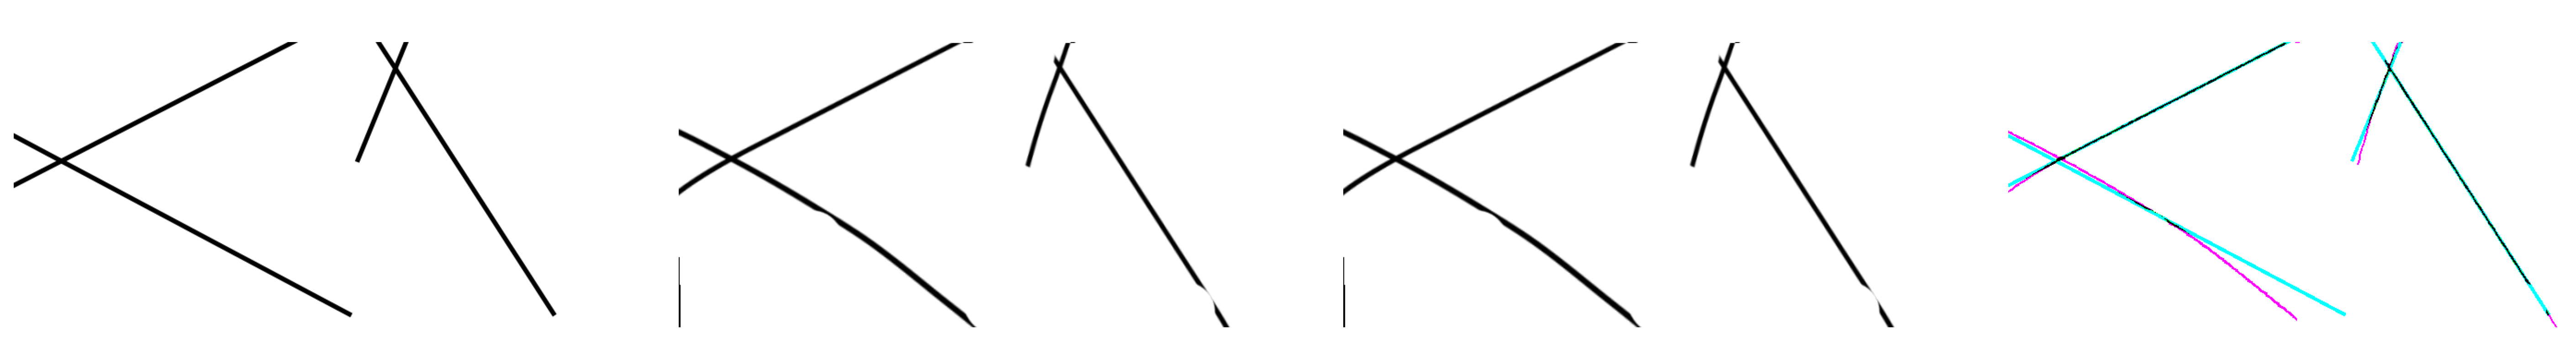

In [6]:
import SimpleITK as sitk
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage import exposure
from skimage.exposure import match_histograms

RGB_IMAGE_DIM = 3
BIN_MASK_DIM = 2

def command_iteration(method):
    print(f"{method.GetOptimizerIteration():3} = {method.GetMetricValue():10.5f}")

def preprocess_image(image):
    """Pre-process image for registration."""
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return exposure.rescale_intensity(image_gray, in_range=(0, 255))

def estimate_bspline_transform(fixed_image, moving_image, fixed_mask, moving_mask, **kwargs):
    bspline_params = {
        "grid_space": 50.0,
        "scale_factors": [1, 2, 5],
        "shrink_factor": [4, 2, 1],
        "smooth_sigmas": [4, 2, 1],
        "num_iterations": 100,
        "sampling_percent": 0.2,
        "learning_rate": 0.5,
        "convergence_min_value": 1e-4,
        "convergence_window_size": 5,
    }
    bspline_params.update(kwargs)

    fixed_image, moving_image = np.squeeze(fixed_image), np.squeeze(moving_image)
    if fixed_image.ndim > RGB_IMAGE_DIM or moving_image.ndim > RGB_IMAGE_DIM:
        raise ValueError("The input images can only be grayscale or RGB images.")
    if (fixed_image.ndim == RGB_IMAGE_DIM and fixed_image.shape[2] != RGB_IMAGE_DIM) or \
       (moving_image.ndim == RGB_IMAGE_DIM and moving_image.shape[2] != RGB_IMAGE_DIM):
        raise ValueError("The input images can only have 3 channels.")

    fixed_image_inv = np.invert(fixed_image)
    moving_image_inv = np.invert(moving_image)

    fixed_mask = np.array(fixed_mask != 0, dtype=np.uint8)
    moving_mask = np.array(moving_mask != 0, dtype=np.uint8)

    fixed_image_inv = cv2.bitwise_and(fixed_image_inv, fixed_image_inv, mask=fixed_mask)
    moving_image_inv = cv2.bitwise_and(moving_image_inv, moving_image_inv, mask=moving_mask)

    fixed_image_inv_sitk = sitk.GetImageFromArray(fixed_image_inv)
    moving_image_inv_sitk = sitk.GetImageFromArray(moving_image_inv)

    fixed_image_inv_sitk = sitk.Cast(fixed_image_inv_sitk, sitk.sitkFloat32)
    moving_image_inv_sitk = sitk.Cast(moving_image_inv_sitk, sitk.sitkFloat32)

    grid_physical_spacing = [bspline_params["grid_space"]] * 2
    image_physical_size = [size * spacing for size, spacing in zip(fixed_image_inv_sitk.GetSize(), fixed_image_inv_sitk.GetSpacing())]
    mesh_size = [int(image_size / grid_spacing + 0.5) for image_size, grid_spacing in zip(image_physical_size, grid_physical_spacing)]
    mesh_size = [int(sz / 4 + 0.5) for sz in mesh_size]

    transform = sitk.BSplineTransformInitializer(fixed_image_inv_sitk, transformDomainMeshSize=mesh_size)
    print(f"Initial Number of B-spline Parameters: {transform.GetNumberOfParameters()}")

    registration_method = sitk.ImageRegistrationMethod()
    registration_method.SetInitialTransformAsBSpline(transform, inPlace=True, scaleFactors=bspline_params["scale_factors"])
    registration_method.SetMetricAsMattesMutualInformation(50)
    registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
    registration_method.SetMetricSamplingPercentage(bspline_params["sampling_percent"], sitk.sitkWallClock)
    registration_method.SetShrinkFactorsPerLevel(bspline_params["shrink_factor"])
    registration_method.SetSmoothingSigmasPerLevel(bspline_params["smooth_sigmas"])
    registration_method.SetOptimizerAsGradientDescentLineSearch(
        learningRate=bspline_params["learning_rate"],
        numberOfIterations=bspline_params["num_iterations"],
        convergenceMinimumValue=bspline_params["convergence_min_value"],
        convergenceWindowSize=bspline_params["convergence_window_size"],
    )
    registration_method.SetInterpolator(sitk.sitkLinear)

    # Add registration progress commands
    registration_method.AddCommand(sitk.sitkIterationEvent, lambda: command_iteration(registration_method))

    bspline_transform = registration_method.Execute(fixed_image_inv_sitk, moving_image_inv_sitk)
    print("-------")
    print(bspline_transform)
    print(f"Optimizer stop condition: {registration_method.GetOptimizerStopConditionDescription()}")
    print(f"Iteration: {registration_method.GetOptimizerIteration()}")
    print(f"Metric value: {registration_method.GetMetricValue()}")

    return bspline_transform

def apply_bspline_transform(fixed_image, moving_image, transform):
    fixed_image_sitk = sitk.GetImageFromArray(fixed_image)
    moving_image_sitk = sitk.GetImageFromArray(moving_image)

    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(fixed_image_sitk)
    resampler.SetInterpolator(sitk.sitkLinear)
    resampler.SetDefaultPixelValue(1)
    resampler.SetTransform(transform)

    registered_image_sitk = resampler.Execute(moving_image_sitk)
    registered_image = sitk.GetArrayFromImage(registered_image_sitk)

    simg1 = sitk.Cast(sitk.RescaleIntensity(fixed_image_sitk), sitk.sitkFloat32)
    simg2 = sitk.Cast(sitk.RescaleIntensity(registered_image_sitk), sitk.sitkFloat32)
    cimg = sitk.Compose(simg1, simg2, simg1 // 2 + simg2 // 2)

    return {"fixed": sitk.GetArrayFromImage(simg1), "moving": sitk.GetArrayFromImage(simg2), "registered": registered_image, "composition": sitk.GetArrayFromImage(cimg)}

def display_images(image_dict):
    fixed_image = image_dict['fixed']
    moving_image = image_dict['moving']
    registered_image = image_dict['registered']
    result_image = image_dict['composition']

    plt.figure(figsize=(24, 6))
    titles = ['Fixed Image', 'Moving Image', 'Registered Image', 'Overlay Image']
    images = [fixed_image, moving_image, registered_image, result_image]

    for i, (title, img) in enumerate(zip(titles, images)):
        plt.subplot(1, 4, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(title)
        plt.axis('off')

    plt.show()

# Load images
fixed_image_path = '/Users/linh/Library/Mobile Documents/com~apple~CloudDocs/example-toy-images-for-registration/data/image-target-1-4.png'
moving_image_path = '/Users/linh/Library/Mobile Documents/com~apple~CloudDocs/example-toy-images-for-registration/data/tiled/image-simple-1-4.png'

fixed_image_data = cv2.imread(fixed_image_path)
print("Shape of fixed image", fixed_image_data.shape)

moving_image_data = cv2.imread(moving_image_path)
print("Shape of moving image", moving_image_data.shape)

fixed_image = preprocess_image(fixed_image_data)
moving_image = preprocess_image(moving_image_data)

# fixed_image, moving_image = match_histograms(fixed_image, moving_image)

fixed_tile = fixed_image
moving_tile = moving_image

fixed_mask = np.ones(shape=fixed_tile.shape, dtype=int)
moving_mask = np.ones(shape=moving_tile.shape, dtype=int)

bspline_transform = estimate_bspline_transform(
    fixed_tile,
    moving_tile,
    fixed_mask,
    moving_mask,
)

result_images = apply_bspline_transform(
    fixed_tile,
    moving_tile,
    bspline_transform,
)

display_images(result_images)


Shape of fixed image (309, 601, 3)
Shape of moving image (385, 675, 3)


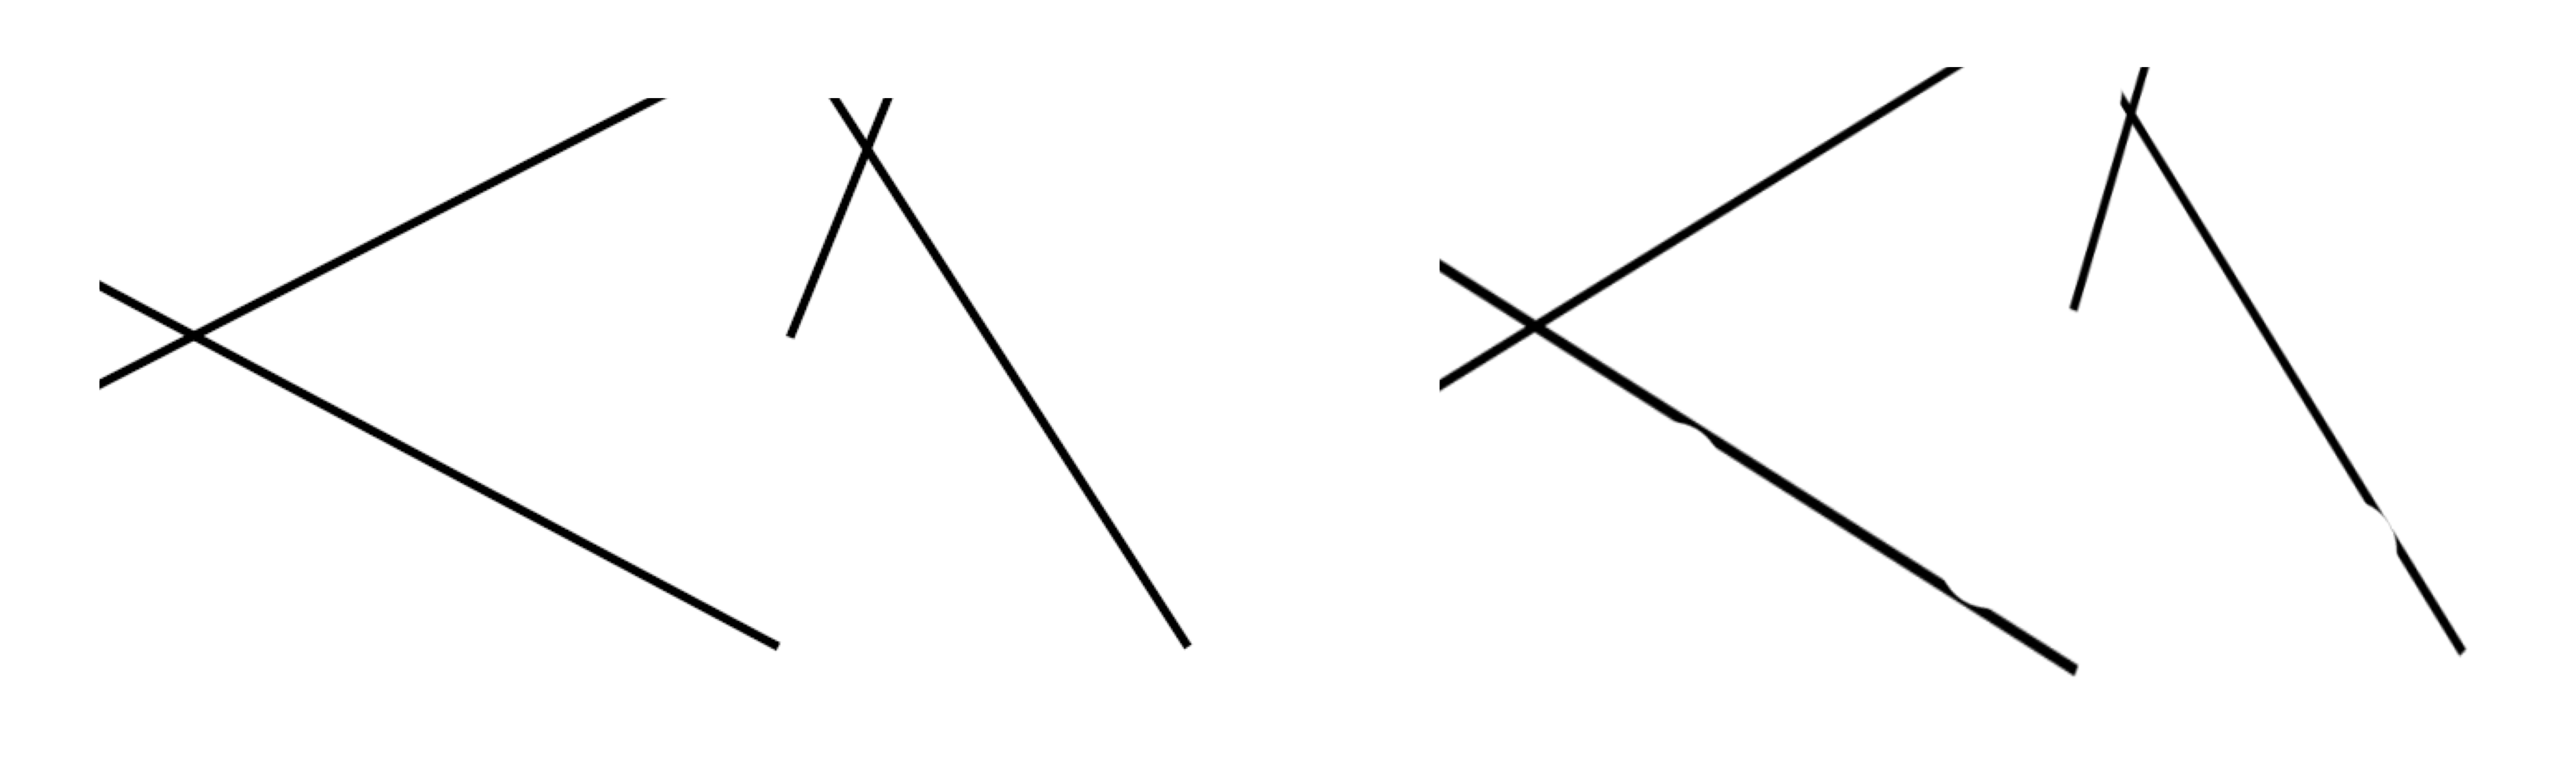

Initial Number of B-spline Parameters: 60
Shape of moving WSI (H&E stitched image) (309, 601)
Shape of fixed WSI (mIF stitched image) (309, 601)
Shape of fixed WSI (mIF stitched image) before expandation (309, 601)
Shape of fixed WSI (mIF stitched image) after expandation (309, 601)
Shape of moving WSI (H&E stitched image) before expandation (309, 601)
Shape of moving WSI (H&E stitched image) after expandation (309, 601, 3)
Shape of registered moving WSI (H&E stitched image) before expandation (309, 601)
Shape of registered moving WSI (H&E stitched image) after expandation (309, 601)


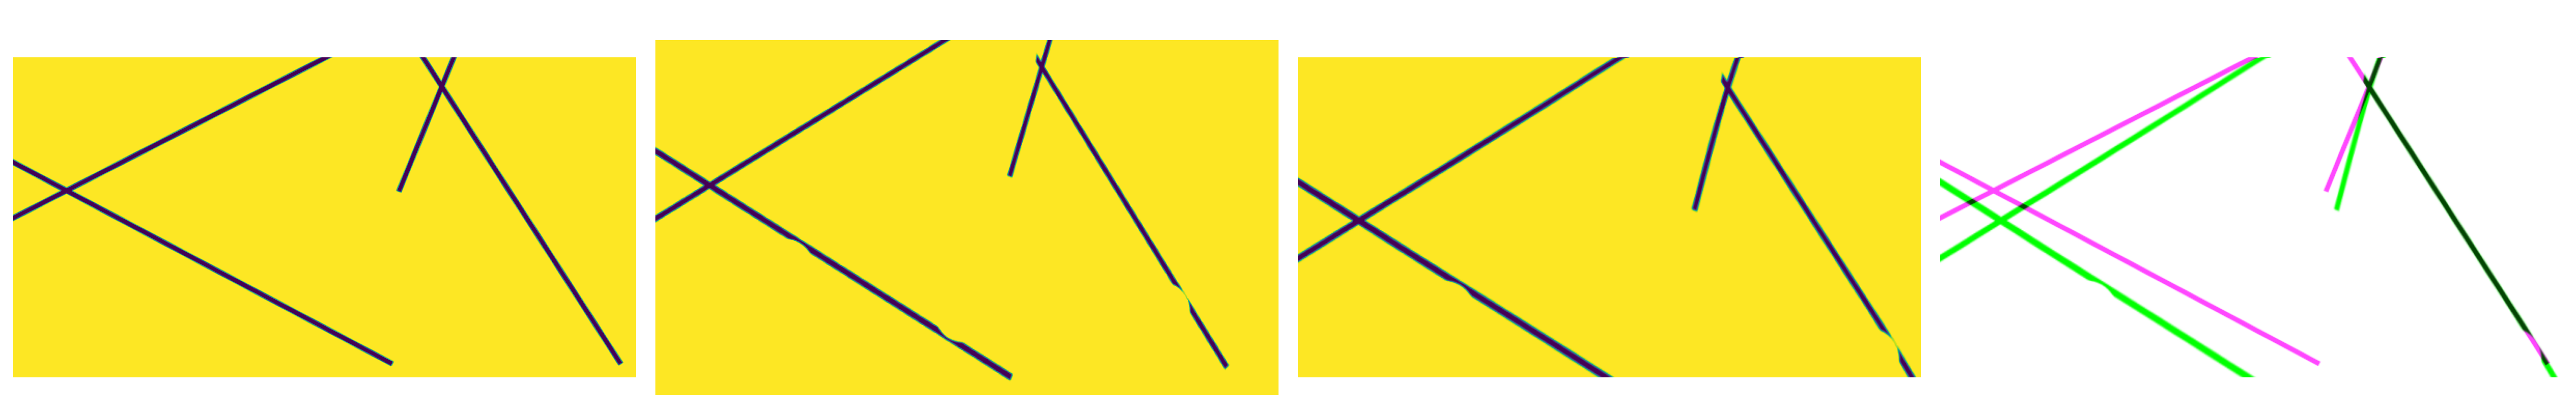

In [44]:
# fixed_image_path = '/Users/linh/Downloads/example-toy-images-for-registration/data/image-target-1-.png'
fixed_image_path = '/Users/linh/Library/Mobile Documents/com~apple~CloudDocs/example-toy-images-for-registration/data/image-target-1-4.png'
# fixed_image_path = '/Users/linh/Downloads/example-toy-images-for-registration/data/image-target-image.png'
moving_image_path = '/Users/linh/Library/Mobile Documents/com~apple~CloudDocs/example-toy-images-for-registration/data/tiled/image-simple-1-4.png'


fixed_image_data = cv2.imread(fixed_image_path)
print("Shape of fixed image", fixed_image_data.shape)

# first_channel_fixed = fixed_image_data[0, :, :]
# three_channel_image_fixed = np.stack([first_channel_fixed] * 3, axis=-1)
# # fixed_image_rgb = Image.fromarray(three_channel_image_fixed.astype('uint8'), 'RGB')

# fixed_image_norm = enhance_contrast(first_channel_fixed, 2, 98)
# # Convert to binary using a lower percentile threshold
# fixed_image_binary = np.where(fixed_image_norm > np.percentile(fixed_image_norm, 90), 1, 0)  # Using 90th percentile for threshold
# fixed_image_color = np.zeros((fixed_image_norm.shape[0], fixed_image_norm.shape[1], 3))
# fixed_image_color[:, :, 1] = fixed_image_binary # Green channel

moving_image_data = cv2.imread(moving_image_path)
print("Shape of moving image", moving_image_data.shape)

# first_channel_moving = moving_image_data[0, :, :]
# three_channel_image_moving = np.stack([first_channel_moving] * 3, axis=-1)

# # moving_image_rgb = Image.fromarray(three_channel_image_moving.astype('uint8'), 'RGB')

# moving_image_norm = enhance_contrast(first_channel_moving, 2, 98)
# # Convert to binary using a lower percentile threshold
# moving_image_binary = np.where(moving_image_norm > np.percentile(moving_image_norm, 90), 1, 0)  # Using 90th percentile for threshold
# moving_image_color = np.zeros((moving_image_norm.shape[0], moving_image_norm.shape[1], 3))
# # moving_image_color[:, :, 1] = moving_image_binary # Green channel
# # Assign the binary mask to the purple channel (red + blue)
# moving_image_color[:, :, 0] = moving_image_binary  # Red channel
# moving_image_color[:, :, 2] = moving_image_binary  # Blue channel



fixed_image = preprocess_image(fixed_image_data)
moving_image = preprocess_image(moving_image_data)

fixed_image, moving_image = match_histograms(fixed_image, moving_image)

# Visualising the results
_, axs = plt.subplots(1, 2, figsize=(15, 10))
axs[0].imshow(fixed_image, cmap="gray")
axs[0].set_title("Fixed Image")
axs[1].imshow(moving_image, cmap="gray")
axs[1].set_title("Moving Image")
plt.show()

fixed_tile = fixed_image
moving_tile = moving_image
# fixed_tile = fixed_image_color
# moving_tile = moving_image_color
fixed_mask = np.ones(shape=fixed_tile.shape, dtype=int)
moving_mask = np.ones(shape=moving_tile.shape, dtype=int)

bspline_transform = estimate_bspline_transform(
    fixed_tile,
    moving_tile,
    fixed_mask,
    moving_mask,
    # grid_space=50.0,
    # scale_factors=[1, 2, 5, 10],
    # shrink_factor=[8, 4, 2, 1],
    # smooth_sigmas=[8, 4, 2, 1],
    # num_iterations=10000,
    # sampling_percent=0.2,
    # learning_rate=1e-6,
    # convergence_min_value=1e-10,
    # covergence_window_size=1
)

bspline_registered_image = apply_bspline_transform(
    fixed_tile,
    moving_tile,
    bspline_transform,
)
bspline_registered_image.shape
common_shape = (min(fixed_tile.shape[0], moving_tile.shape[0], bspline_registered_image.shape[0]),
                min(fixed_tile.shape[1], moving_tile.shape[1], bspline_registered_image.shape[1]))

# Assume fixed_tile, moving_tile, and bspline_registered_image are 2D arrays (grayscale images)

# Since they are 2D, there is no need to index the third dimension.
# If you need a 3-channel image for some reason, you can duplicate the grayscale image across three channels:
fixed_tile = resize_image(fixed_tile, common_shape)
moving_tile = resize_image(moving_tile, common_shape)
bspline_registered_image = resize_image(bspline_registered_image, common_shape)
print(f'Shape of moving WSI (H&E stitched image) {moving_tile.shape}')
print(f'Shape of fixed WSI (mIF stitched image) {fixed_tile.shape}')

tile_overlay = np.stack([moving_tile, fixed_tile, moving_tile], axis=-1)
bspline_overlay = np.stack([bspline_registered_image, fixed_tile, bspline_registered_image], axis=-1)

print(f'Shape of fixed WSI (mIF stitched image) before expandation {fixed_tile.shape}')
fixed_tile = np.repeat(np.expand_dims(fixed_tile, axis=2), 3, axis=2)
print(f'Shape of fixed WSI (mIF stitched image) after expandation {moving_tile.shape}')
# Transpose moviing_tile array
fixed_tile = np.transpose(fixed_tile, (2, 0, 1))
first_channel_fixed = fixed_tile[0, :, :]
# Enhance contrast
fixed_image_norm = enhance_contrast(first_channel_fixed, 2, 98)

# Convert to binary using a lower percentile threshold
fixed_image_binary = np.where(fixed_image_norm > np.percentile(fixed_image_norm, 90), 1, 0)  # Using 90th percentile for threshold

# Initialize the RGB image with zeros (black background)
fixed_image_color = np.zeros((fixed_image_norm.shape[0], fixed_image_norm.shape[1], 3))

# Assign the binary mask to the purple channel (red + blue)
# fixed_image_color[:, :, 0] = fixed_image_binary  # Red channel
fixed_image_color[:, :, 1] = fixed_image_binary  # Green channel
# fixed_image_color[:, :, 2] = fixed_image_binary  # Blue channel

print(f'Shape of moving WSI (H&E stitched image) before expandation {moving_tile.shape}')
moving_tile = np.repeat(np.expand_dims(moving_tile, axis=2), 3, axis=2)
print(f'Shape of moving WSI (H&E stitched image) after expandation {moving_tile.shape}')
# Transpose moviing_tile array
moving_tile = np.transpose(moving_tile, (2, 0, 1))
first_channel_moving = moving_tile[0, :, :]
# Enhance contrast
moving_image_norm = enhance_contrast(first_channel_moving, 2, 98)

# Convert to binary using a lower percentile threshold
moving_image_binary = np.where(moving_image_norm > np.percentile(moving_image_norm, 90), 1, 0)  # Using 90th percentile for threshold

# Initialize the RGB image with zeros (black background)
moving_image_color = np.zeros((moving_image_norm.shape[0], moving_image_norm.shape[1], 3))

# Assign the binary mask to the purple channel (red + blue)
moving_image_color[:, :, 0] = moving_image_binary  # Red channel
moving_image_color[:, :, 2] = moving_image_binary  # Blue channel

print(f'Shape of registered moving WSI (H&E stitched image) before expandation {bspline_registered_image.shape}')
bspline_registered_tile = np.repeat(np.expand_dims(bspline_registered_image, axis=2), 3, axis=2)
print(f'Shape of registered moving WSI (H&E stitched image) after expandation {bspline_registered_image.shape}')
# Transpose moviing_tile array
bspline_registered_tile = np.transpose(bspline_registered_tile, (2, 0, 1))
first_channel_moving = bspline_registered_tile[0, :, :]
# Enhance contrast
bspline_registered_norm = enhance_contrast(first_channel_moving, 2, 98)

# Convert to binary using a lower percentile threshold
bspline_registered_binary = np.where(bspline_registered_norm > np.percentile(bspline_registered_norm, 90), 1, 0)  # Using 90th percentile for threshold

# Initialize the RGB image with zeros (black background)
bspline_registered_color = np.zeros((bspline_registered_norm.shape[0], bspline_registered_norm.shape[1], 3))

# Assign the binary mask to the purple channel (red + blue)
bspline_registered_color[:, :, 0] = bspline_registered_binary  # Red channel
bspline_registered_color[:, :, 2] = bspline_registered_binary  # Blue channel

fig, axs = plt.subplots(1, 4, figsize=(20, 15))
axs[0].imshow(fixed_image, cmap='viridis' )
axs[0].set_title("mIF WSI", fontsize=12, fontweight='bold')

axs[1].imshow(moving_image, cmap='viridis' )
axs[1].set_title("H&E WSI before registration", fontsize=12, fontweight='bold')

axs[2].imshow(bspline_registered_image )
axs[2].set_title("Registered H&E WSI", fontsize=12, fontweight='bold')

# axs[1].imshow(tile_overlay, cmap="gray")
# axs[1].set_title("Before B-spline Transform")
axs[3].imshow(bspline_overlay)
axs[3].set_title("Overlay WSIs After B-spline Transform", fontsize=12, fontweight='bold')

for ax in axs:
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.axis('off') 
# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.85)  # Adjust the top to ensure titles are within the figure
# plt.savefig("debug_image.png")
plt.show()

Shape of fixed image (309, 601, 3)
Shape of moving image (385, 675, 3)
Initial Number of B-spline Parameters: 60
  0 =   -0.12587
  1 =   -0.12588
  2 =   -0.12593
  3 =   -0.12613
  4 =   -0.12685
  5 =   -0.12971
  6 =   -0.14798
  7 =   -0.19687
  8 =   -0.27004
  9 =   -0.30018
 10 =   -0.30909
 11 =   -0.32004
 12 =   -0.32749
 13 =   -0.34061
 14 =   -0.36961
 15 =   -0.37593
 16 =   -0.38399
 17 =   -0.38834
 18 =   -0.39530
 19 =   -0.39789
 20 =   -0.40553
 21 =   -0.40875
 22 =   -0.41049
 23 =   -0.41128
 24 =   -0.41180
 25 =   -0.41215
 26 =   -0.41248
 27 =   -0.41281
 28 =   -0.41313
 29 =   -0.41351
  0 =   -0.23462
  1 =   -0.24210
  2 =   -0.24727
  3 =   -0.24951
  4 =   -0.25067
  5 =   -0.25161
  6 =   -0.25249
  7 =   -0.25328
  8 =   -0.25404
  9 =   -0.25472
 10 =   -0.25546
 11 =   -0.25607
 12 =   -0.25687
 13 =   -0.25775
 14 =   -0.25921
 15 =   -0.25994
 16 =   -0.26068
 17 =   -0.26128
 18 =   -0.26231
 19 =   -0.26277
 20 =   -0.26378
 21 =   -0.26436
 22

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


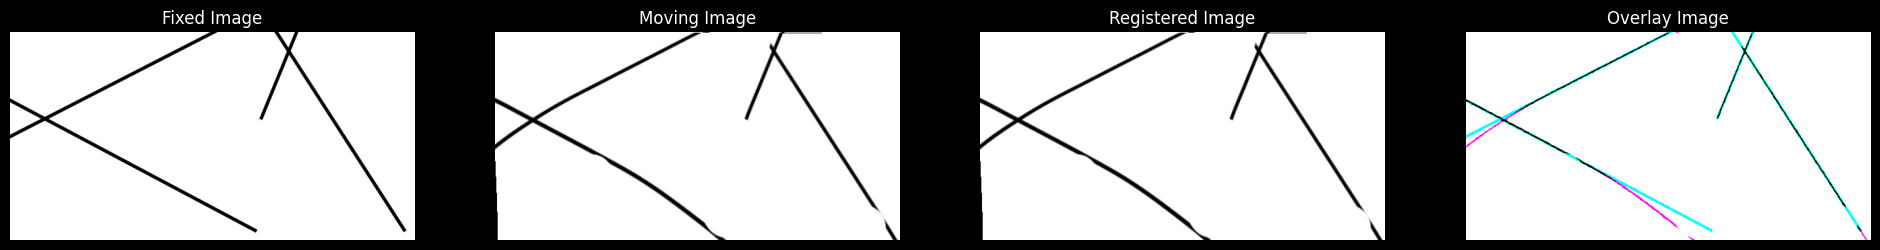

In [7]:
import SimpleITK as sitk
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage import exposure

RGB_IMAGE_DIM = 3
BIN_MASK_DIM = 2

def command_iteration(method):
    print(f"{method.GetOptimizerIteration():3} = {method.GetMetricValue():10.5f}")

def preprocess_image(image):
    if image.shape[-1] == 3:
        image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        image_gray = image[..., 0]  # Use the first channel for multi-channel images
    return exposure.rescale_intensity(image_gray, in_range=(0, 255))

def display_images(image_dict):
    fixed_image = image_dict['fixed']
    moving_image = image_dict['moving']
    registered_image = image_dict['registered']
    result_image = image_dict['composition']

    plt.figure(figsize=(24, 6))
    titles = ['Fixed Image', 'Moving Image', 'Registered Image', 'Overlay Image']
    images = [fixed_image, moving_image, registered_image, result_image]

    for i, (title, img) in enumerate(zip(titles, images)):
        plt.subplot(1, 4, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(title)
        plt.axis('off')

    plt.show()

def bspline_registration(fixed_image, moving_image, fixed_mask, moving_mask, **kwargs):
    bspline_params = {
        "grid_space": 50.0,
        "scale_factors": [1, 2, 5],
        "shrink_factor": [4, 2, 1],
        "smooth_sigmas": [4, 2, 1],
        "num_iterations": 100,
        "sampling_percent": 0.2,
        "learning_rate": 0.5,
        "convergence_min_value": 1e-4,
        "convergence_window_size": 5,
    }
    bspline_params.update(kwargs)

    fixed_image, moving_image = np.squeeze(fixed_image), np.squeeze(moving_image)
    if fixed_image.ndim > RGB_IMAGE_DIM or moving_image.ndim > RGB_IMAGE_DIM:
        raise ValueError("The input images can only be grayscale or RGB images.")
    if (fixed_image.ndim == RGB_IMAGE_DIM and fixed_image.shape[2] != RGB_IMAGE_DIM) or \
       (moving_image.ndim == RGB_IMAGE_DIM and moving_image.shape[2] != RGB_IMAGE_DIM):
        raise ValueError("The input images can only have 3 channels.")

    fixed_image_inv = np.invert(fixed_image)
    moving_image_inv = np.invert(moving_image)

    fixed_mask = np.array(fixed_mask != 0, dtype=np.uint8)
    moving_mask = np.array(moving_mask != 0, dtype=np.uint8)

    fixed_image_inv = cv2.bitwise_and(fixed_image_inv, fixed_image_inv, mask=fixed_mask)
    moving_image_inv = cv2.bitwise_and(moving_image_inv, moving_image_inv, mask=moving_mask)

    fixed_image_inv_sitk = sitk.GetImageFromArray(fixed_image_inv)
    moving_image_inv_sitk = sitk.GetImageFromArray(moving_image_inv)

    fixed_image_inv_sitk = sitk.Cast(fixed_image_inv_sitk, sitk.sitkFloat32)
    moving_image_inv_sitk = sitk.Cast(moving_image_inv_sitk, sitk.sitkFloat32)

    grid_physical_spacing = [bspline_params["grid_space"]] * 2
    image_physical_size = [size * spacing for size, spacing in zip(fixed_image_inv_sitk.GetSize(), fixed_image_inv_sitk.GetSpacing())]
    mesh_size = [int(image_size / grid_spacing + 0.5) for image_size, grid_spacing in zip(image_physical_size, grid_physical_spacing)]
    mesh_size = [int(sz / 4 + 0.5) for sz in mesh_size]

    transform = sitk.BSplineTransformInitializer(fixed_image_inv_sitk, transformDomainMeshSize=mesh_size)
    print(f"Initial Number of B-spline Parameters: {transform.GetNumberOfParameters()}")

    registration_method = sitk.ImageRegistrationMethod()
    registration_method.SetInitialTransformAsBSpline(transform, inPlace=True, scaleFactors=bspline_params["scale_factors"])
    registration_method.SetMetricAsMattesMutualInformation(50)
    registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
    registration_method.SetMetricSamplingPercentage(bspline_params["sampling_percent"], sitk.sitkWallClock)
    registration_method.SetShrinkFactorsPerLevel(bspline_params["shrink_factor"])
    registration_method.SetSmoothingSigmasPerLevel(bspline_params["smooth_sigmas"])
    registration_method.SetOptimizerAsGradientDescentLineSearch(
        learningRate=bspline_params["learning_rate"],
        numberOfIterations=bspline_params["num_iterations"],
        convergenceMinimumValue=bspline_params["convergence_min_value"],
        convergenceWindowSize=bspline_params["convergence_window_size"],
    )
    registration_method.SetInterpolator(sitk.sitkLinear)

    # Add registration progress commands
    registration_method.AddCommand(sitk.sitkIterationEvent, lambda: command_iteration(registration_method))

    bspline_transform = registration_method.Execute(fixed_image_inv_sitk, moving_image_inv_sitk)
    print("-------")
    print(bspline_transform)
    print(f"Optimizer stop condition: {registration_method.GetOptimizerStopConditionDescription()}")
    print(f"Iteration: {registration_method.GetOptimizerIteration()}")
    print(f"Metric value: {registration_method.GetMetricValue()}")

    fixed_image_sitk = sitk.GetImageFromArray(fixed_image)
    moving_image_sitk = sitk.GetImageFromArray(moving_image)

    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(fixed_image_sitk)
    resampler.SetInterpolator(sitk.sitkLinear)
    resampler.SetDefaultPixelValue(1)
    resampler.SetTransform(bspline_transform)

    registered_image_sitk = resampler.Execute(moving_image_sitk)
    registered_image = sitk.GetArrayFromImage(registered_image_sitk)

    simg1 = sitk.Cast(sitk.RescaleIntensity(fixed_image_sitk), sitk.sitkFloat32)
    simg2 = sitk.Cast(sitk.RescaleIntensity(registered_image_sitk), sitk.sitkFloat32)
    cimg = sitk.Compose(simg1, simg2, simg1 // 2 + simg2 // 2)

    return {
        "fixed": sitk.GetArrayFromImage(simg1),
        "moving": sitk.GetArrayFromImage(simg2),
        "registered": registered_image,
        "composition": sitk.GetArrayFromImage(cimg)
    }

# Example usage
fixed_image_path = '/Users/linh/Library/Mobile Documents/com~apple~CloudDocs/example-toy-images-for-registration/data/image-target-1-4.png'
# fixed_image_path = '/Users/linh/Downloads/example-toy-images-for-registration/data/image-target-image.png'
moving_image_path = '/Users/linh/Library/Mobile Documents/com~apple~CloudDocs/example-toy-images-for-registration/data/tiled/image-simple-1-4.png'

fixed_image_data = cv2.imread(fixed_image_path)
print("Shape of fixed image", fixed_image_data.shape)

moving_image_data = cv2.imread(moving_image_path)
print("Shape of moving image", moving_image_data.shape)

fixed_image = preprocess_image(fixed_image_data)
moving_image = preprocess_image(moving_image_data)

fixed_mask = np.ones(shape=fixed_image.shape, dtype=int)
moving_mask = np.ones(shape=moving_image.shape, dtype=int)

result_images = bspline_registration(
    fixed_image,
    moving_image,
    fixed_mask,
    moving_mask,
    grid_space=50.0,
    scale_factors=[1, 2, 5],
    shrink_factor=[4, 2, 1],
    smooth_sigmas=[4, 2, 1],
    num_iterations=100,
    sampling_percent=0.2,
    learning_rate=0.5,
    convergence_min_value=1e-4,
    convergence_window_size=5
)

display_images(result_images)
